### Regressão Logística

In [1]:
# Importando os módulos necessários para o processamento dos dados
import numpy   as np
import pandas  as pd

# Módulos necessários para visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importando os módulos auxiliares

from sklearn.model_selection import train_test_split # Divisão de conjunto de treinamento e teste
from sklearn.model_selection import cross_validate # Validação cruzada do modelo
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV # Busca pelos melhores hiperparâmetros
from sklearn.externals import joblib # Necessário para salvar os modelos treinados em arquivos externos
from imblearn.over_sampling import SMOTE # Balanceamento de classes
from sklearn.preprocessing import LabelEncoder

# Métricas de avaliação

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools

# Permite que o interpretador de latex (que aceita unicode) seja usado nos textos

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

# Função auxiliar para plotar a matriz de confusão. 
# Retirada de: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    
def gerar_dataset_balanceado(train_data, 
                             train_target, 
                             test_data, 
                             test_target):
    
    sm = SMOTE(random_state=0, ratio='minority')
    
    encoders = list()
    
    for i in range(2): # Repete duas vezes o loop: um para o conjunto de treino e outro para o de teste
        if i == 0:
            data = train_data
            target = train_target
        elif i == 1:
            data = test_data
            target = test_target
    
        for feature in train_data.select_dtypes('object').columns:
            lb = LabelEncoder()

            lb.fit(data[feature])
            data[feature] = list(lb.transform(data[feature]))
            data[feature] = data[feature].astype('object')

            encoders.append(lb)

        data_b, target_b = sm.fit_sample(data, target)
    #     train_data_b = train_data_b.astype('int64')

    #     train_data_b = pd.DataFrame(train_data_b, columns=pd.get_dummies(train_data).columns)
        data_b = pd.DataFrame(data_b, columns=data.columns)
        data_b['earnings'] = target_b
        data_b = data_b.sample(frac=1) # Embaralha os registros

        target_b = data_b['earnings']
        data_b.drop(columns='earnings', inplace=True)

        for idx, feature in enumerate(data.select_dtypes('object').columns):

            data[feature] = encoders[idx].inverse_transform(list(data[feature]))

            data_b[feature] = data_b[feature].astype('int64')
            data_b[feature] = encoders[idx].inverse_transform(list(data_b[feature]))
        
        if i == 0:
            train_data_b = data_b
            train_target_b = target_b
        elif i == 1:
            test_data_b = data_b
            test_target_b = target_b
    
#     test_data_b, test_target_b = sm.fit_sample(pd.get_dummies(test_data), test_target)

#     test_data_b = pd.DataFrame(test_data_b, columns=pd.get_dummies(test_data).columns)
#     test_data_b['earnings'] = test_target_b
#     test_data_b = test_data_b.sample(frac=1) # Embaralha os registros
    
#     test_target_b = test_data_b['earnings']
#     test_data_b.drop(columns='earnings', inplace=True)
    
    return train_data_b, train_target_b, test_data_b, test_target_b

def exibir_resultados_finais(clf, 
                             test_data, 
                             test_target, 
                             id_abordagem, 
                             str_balanceamento, 
                             path_arquivos,
                             tipo_classificador,
                             fracao_dataset=0.1,
                             salvar_resultados=False):
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False
    
    # Classificando o conjunto de teste

    predicoes = clf.predict(test_data)

    if tipo_classificador == 'arvore':
    
        # Salvando a árvore treinada graficamente

        export_graphviz(clf, 
                        out_file=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.dot', 
                        feature_names=test_data.columns,  
                        class_names=['Less than or equal to', 'More than'],  
                        filled=True, rounded=True,  
                        special_characters=True)  

    # Avaliando o desempenho

    # Matriz de confusão

    cfs_mtx = confusion_matrix(test_target, predicoes)
    plt.figure(figsize=(20,10))
    sns.set(font_scale=2)
    ax = sns.heatmap(cfs_mtx, 
                     xticklabels=['$\leq50$K', '$>50$K'], 
                     yticklabels=['$\leq50$K', '$>50$K'], 
                     annot=cfs_mtx,
                     fmt='d',
                     cbar=None)

    ax.set_xlabel('Predito', labelpad=20, fontsize=30)
    ax.set_ylabel('Real', labelpad=20, fontsize=30)
    ax.set_title('Matriz de Confusão')
    
    acc = accuracy_score(test_target, predicoes)
    pre = precision_score(test_target, predicoes)
    rec = recall_score(test_target, predicoes)
    f1 = f1_score(test_target, predicoes)
    
    if tipo_classificador in ['svm-rbf','svm-linear']:
        predicoes = clf.decision_function(test_data)
    elif tipo_classificador in ['arvore','naive-bayes','logit','knn','rf']:
        predicoes = clf.predict_proba(test_data)[:,1]
    
    roc_auc = roc_auc_score(test_target, predicoes)
    prc_auc = average_precision_score(test_target, predicoes)

    print('Acurácia: %.3f %%' % (acc*100))
    print('Precisão: %.3f %%' % (pre*100))
    print('Recall: %.3f %%' % (rec*100))
    print('F1 score: %3f %%' % (f1*100))
    print('ROC AUC: %.3f %%' % (roc_auc*100))
    print('PRC AUC: %.3f %%' % (prc_auc*100))

    # plot_confusion_matrix(cfs_mtx, ['<=50K', '>50K'], normalize=False)
    
    if salvar_resultados:
        if tipo_classificador == 'arvore':
            path_graficos = 'Classificadores/Arvores-decisao/'
        elif tipo_classificador in ['svm-linear', 'svm-rbf']:
            path_graficos = 'Classificadores/SVM/'
        elif tipo_classificador == 'naive-bayes':
            path_graficos = 'Classificadores/Naive-bayes/'
        elif tipo_classificador == 'logit':
            path_graficos = 'Classificadores/Regressao-logistica/'
        elif tipo_classificador == 'knn':
            path_graficos = 'Classificadores/kNN/'
        elif tipo_classificador == 'rf':
            path_graficos = 'Classificadores/Random-forest/'
        elif tipo_classificador == 'mlp':
            path_graficos = 'Classificadores/Redes-neurais-MLP-2/'
        
        joblib.dump(predicoes,
                    path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-predicoes.pkl')    
        
        filename = path_graficos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-matriz-confusao.png'
        plt.savefig(filename)
        
        d = {'Acuracia': acc, 
             'Precisao': pre, 
             'Recall': rec, 
             'F1': f1,
             'ROC AUC': roc_auc, 
             'PRC AUC': prc_auc}
        
        temp = pd.Series(data=d).to_csv(path=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-medidas.csv', sep=',')
        
        
    plt.show()
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False

# ATENÇÃO!!! Escolher corretamente qual a fração do dataset que está sendo utilizada

fracao_dataset = 0.1

In [2]:
# Importando os arquivos com os datasets pré-processados

path_arquivos = 'Data/'

data_pre_proc_1 = pd.read_csv(path_arquivos+'data-pre-proc-1.csv')
data_pre_proc_2 = pd.read_csv(path_arquivos+'data-pre-proc-2.csv')
data_pre_proc_3 = pd.read_csv(path_arquivos+'data-pre-proc-3.csv')
data_pre_proc_4 = pd.read_csv(path_arquivos+'data-pre-proc-4.csv')

# Descartando a primeira coluna, que é só identificador do registro

data_pre_proc_1 = data_pre_proc_1.iloc[:,1::]
data_pre_proc_2 = data_pre_proc_2.iloc[:,1::]
data_pre_proc_3 = data_pre_proc_3.iloc[:,1::]
data_pre_proc_4 = data_pre_proc_4.iloc[:,1::]

# Separando o target e dividindo os conjuntos de treino e teste para cada dataset

# Dataset 1

# data_pre_proc_1 = data_pre_proc_1[data_pre_proc_1['investment-status'] != data_pre_proc_1['investment-status'].max()]
# data_pre_proc_1 = data_pre_proc_1[data_pre_proc_1['fnlwgt'] != data_pre_proc_1['fnlwgt'].max()]

target_1 = data_pre_proc_1['earnings']
data_pre_proc_1.drop(columns='earnings', inplace=True)

train_data_1, test_data_1, train_target_1, test_target_1 = train_test_split(
    data_pre_proc_1, target_1, test_size=0.33, random_state=0)

train_data_b_1, train_target_b_1, test_data_b_1, test_target_b_1 = gerar_dataset_balanceado(
    train_data_1, train_target_1, test_data_1, test_target_1)

# Dataset 2

target_2 = data_pre_proc_2['earnings']
data_pre_proc_2.drop(columns='earnings', inplace=True)

train_data_2, test_data_2, train_target_2, test_target_2 = train_test_split(
    data_pre_proc_2, target_2, test_size=0.33, random_state=0)

train_data_b_2, train_target_b_2, test_data_b_2, test_target_b_2 = gerar_dataset_balanceado(
    train_data_2, train_target_2, test_data_2, test_target_2)
    
# Dataset 3
    
target_3 = data_pre_proc_3['earnings']
data_pre_proc_3.drop(columns='earnings', inplace=True)

train_data_3, test_data_3, train_target_3, test_target_3 = train_test_split(
    data_pre_proc_3, target_3, test_size=0.33, random_state=0)

train_data_b_3, train_target_b_3, test_data_b_3, test_target_b_3 = gerar_dataset_balanceado(
    train_data_3, train_target_3, test_data_3, test_target_3)
    
# Dataset 4    

target_4 = data_pre_proc_4['earnings']
data_pre_proc_4.drop(columns='earnings', inplace=True)

train_data_4, test_data_4, train_target_4, test_target_4 = train_test_split(
    data_pre_proc_4, target_4, test_size=0.33, random_state=0)

train_data_b_4, train_target_b_4, test_data_b_4, test_target_b_4 = gerar_dataset_balanceado(
    train_data_4, train_target_4, test_data_4, test_target_4)

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to c

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

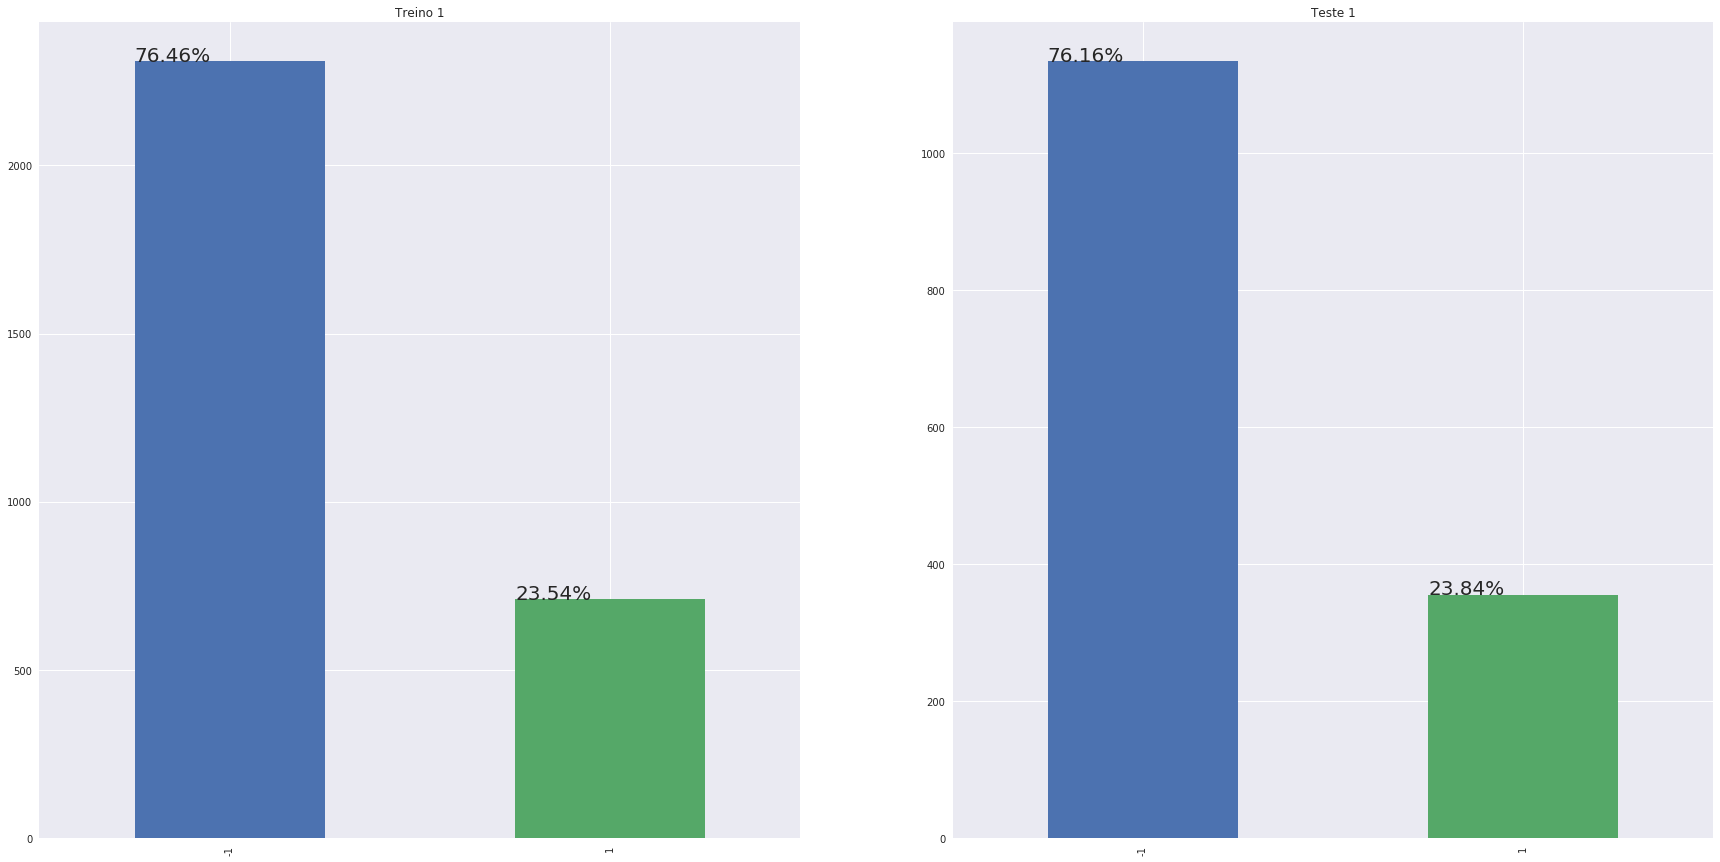

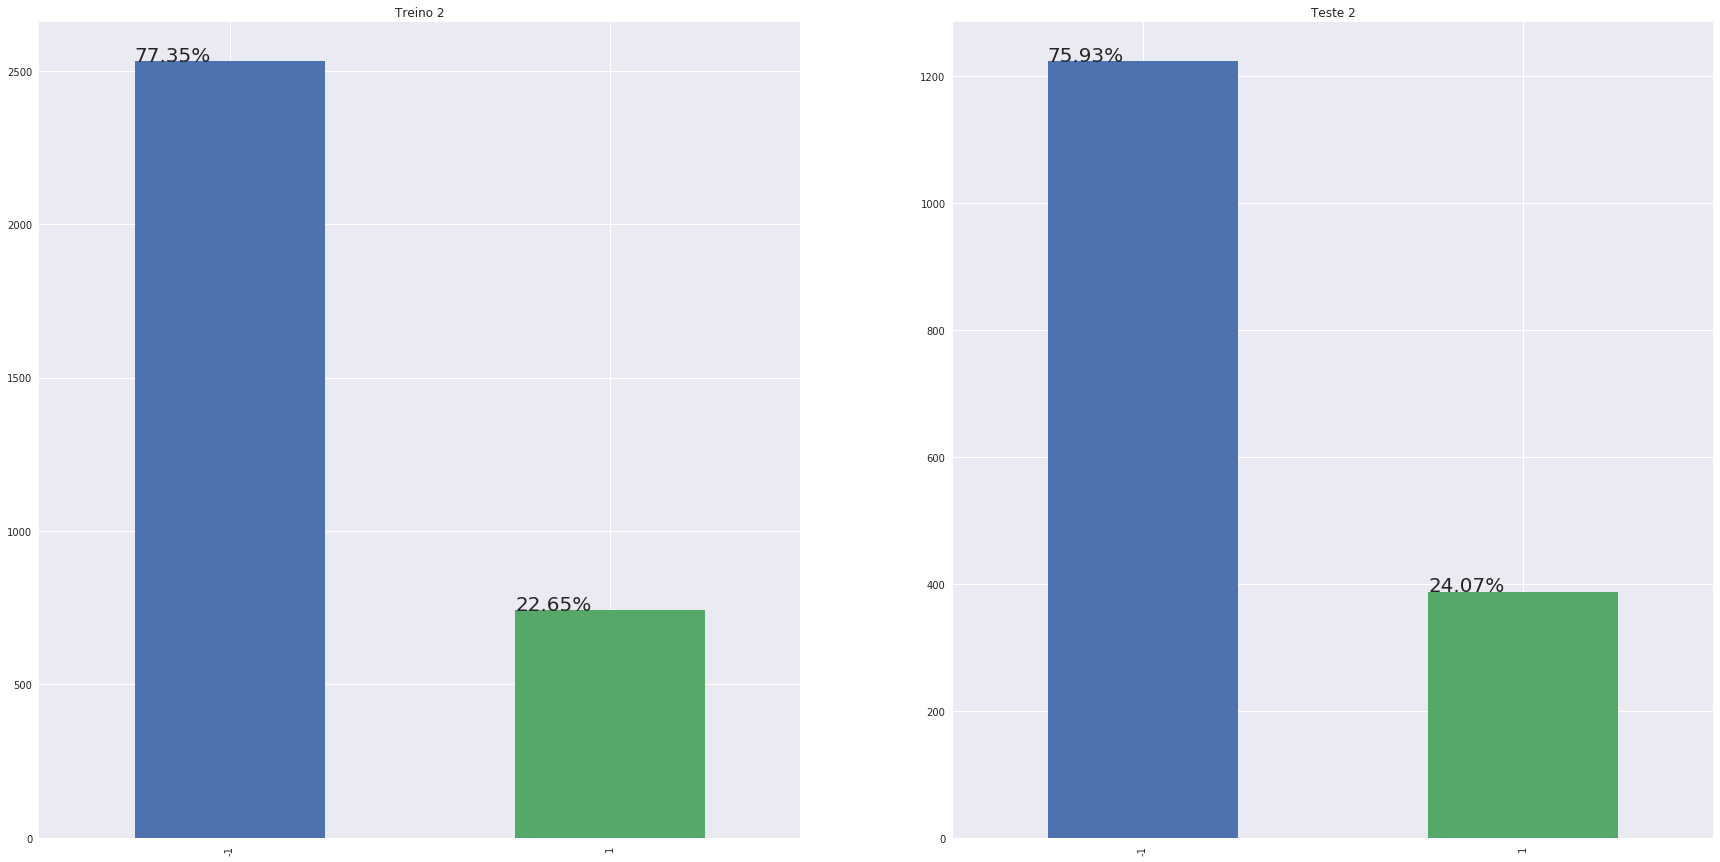

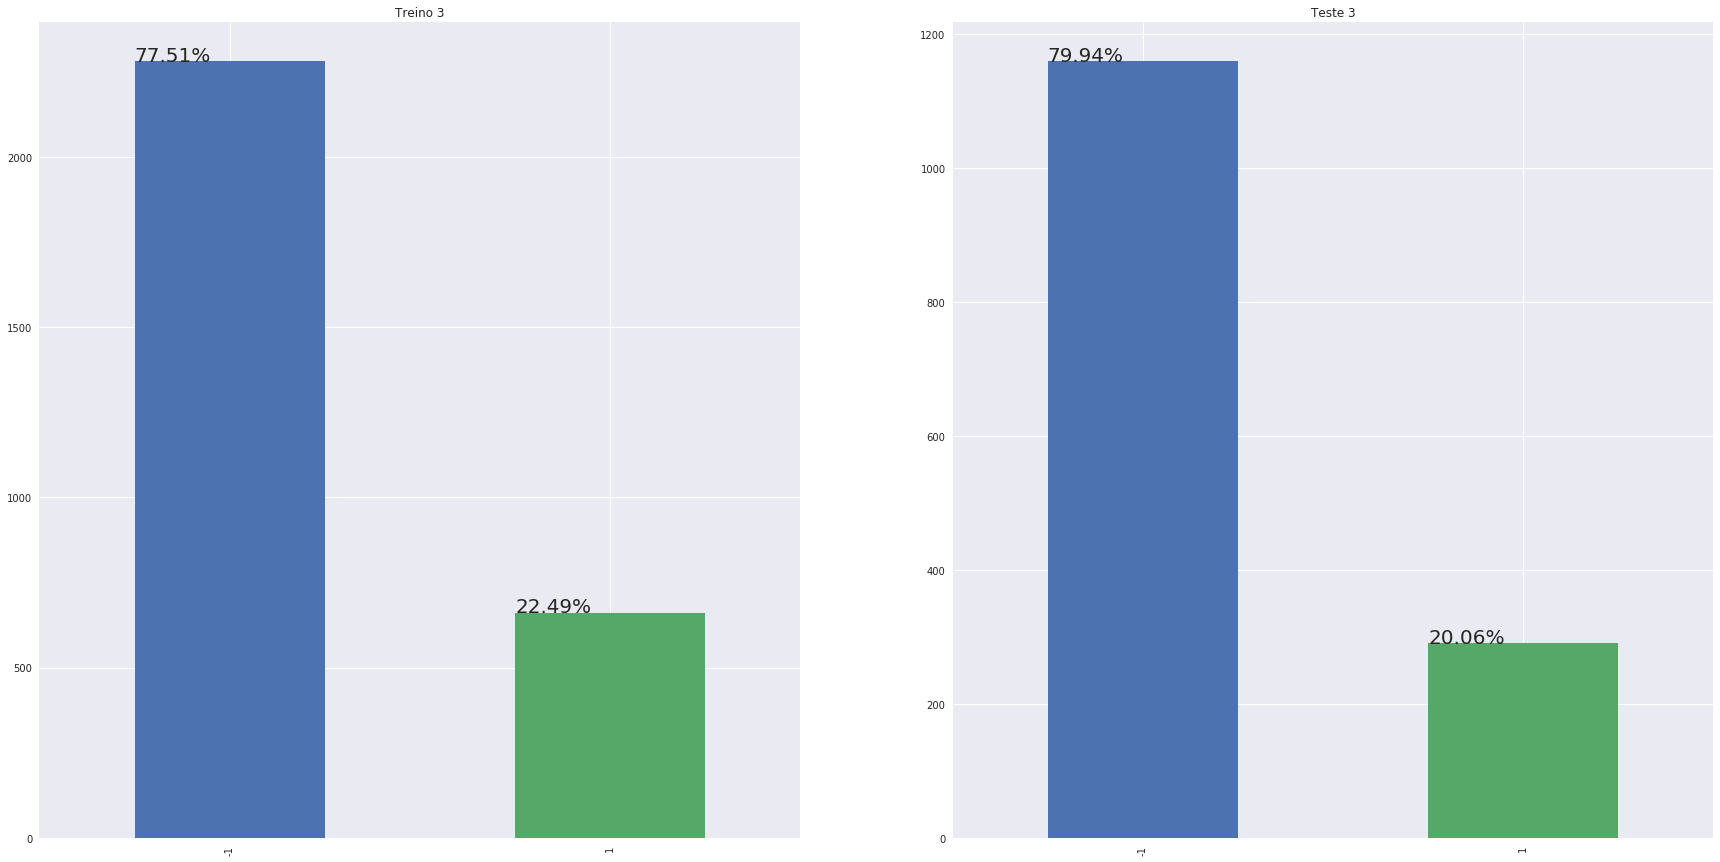

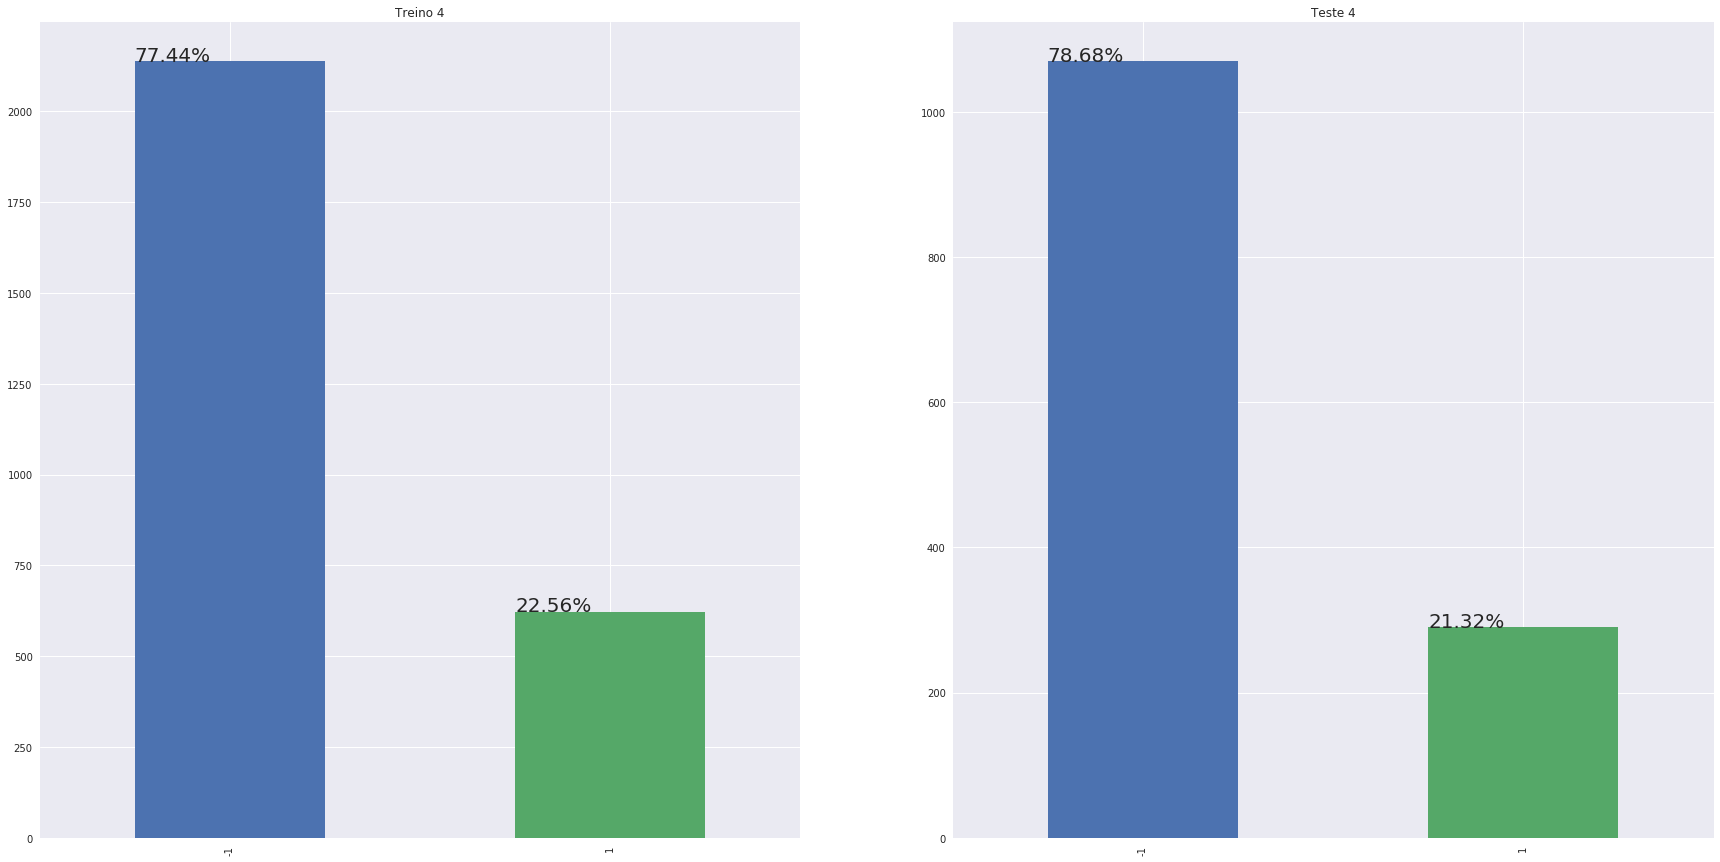

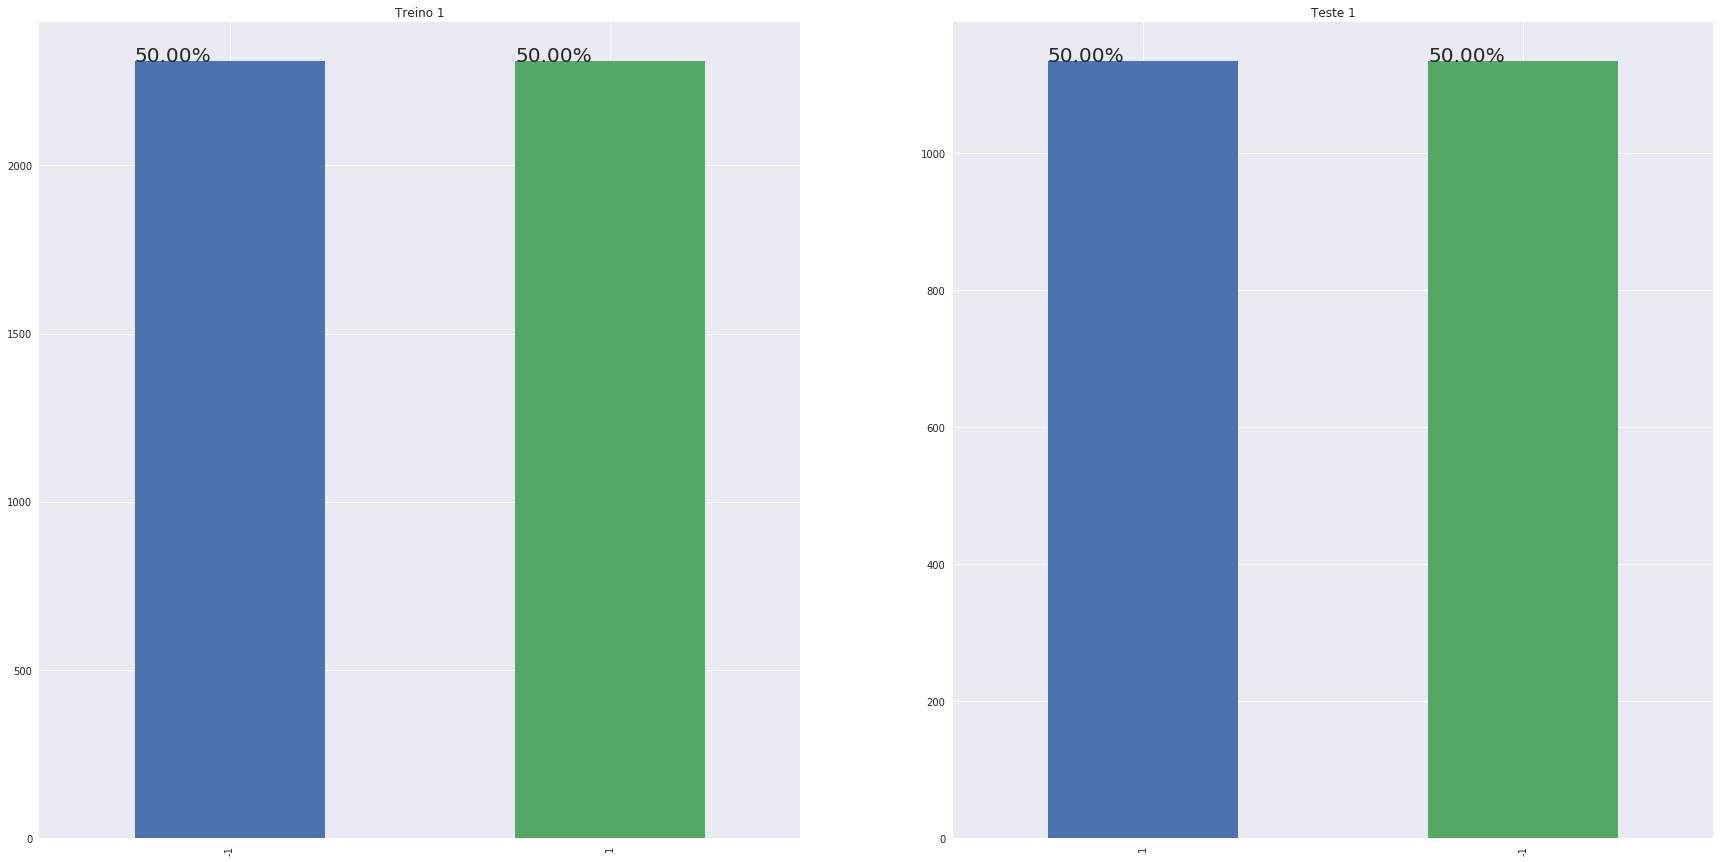

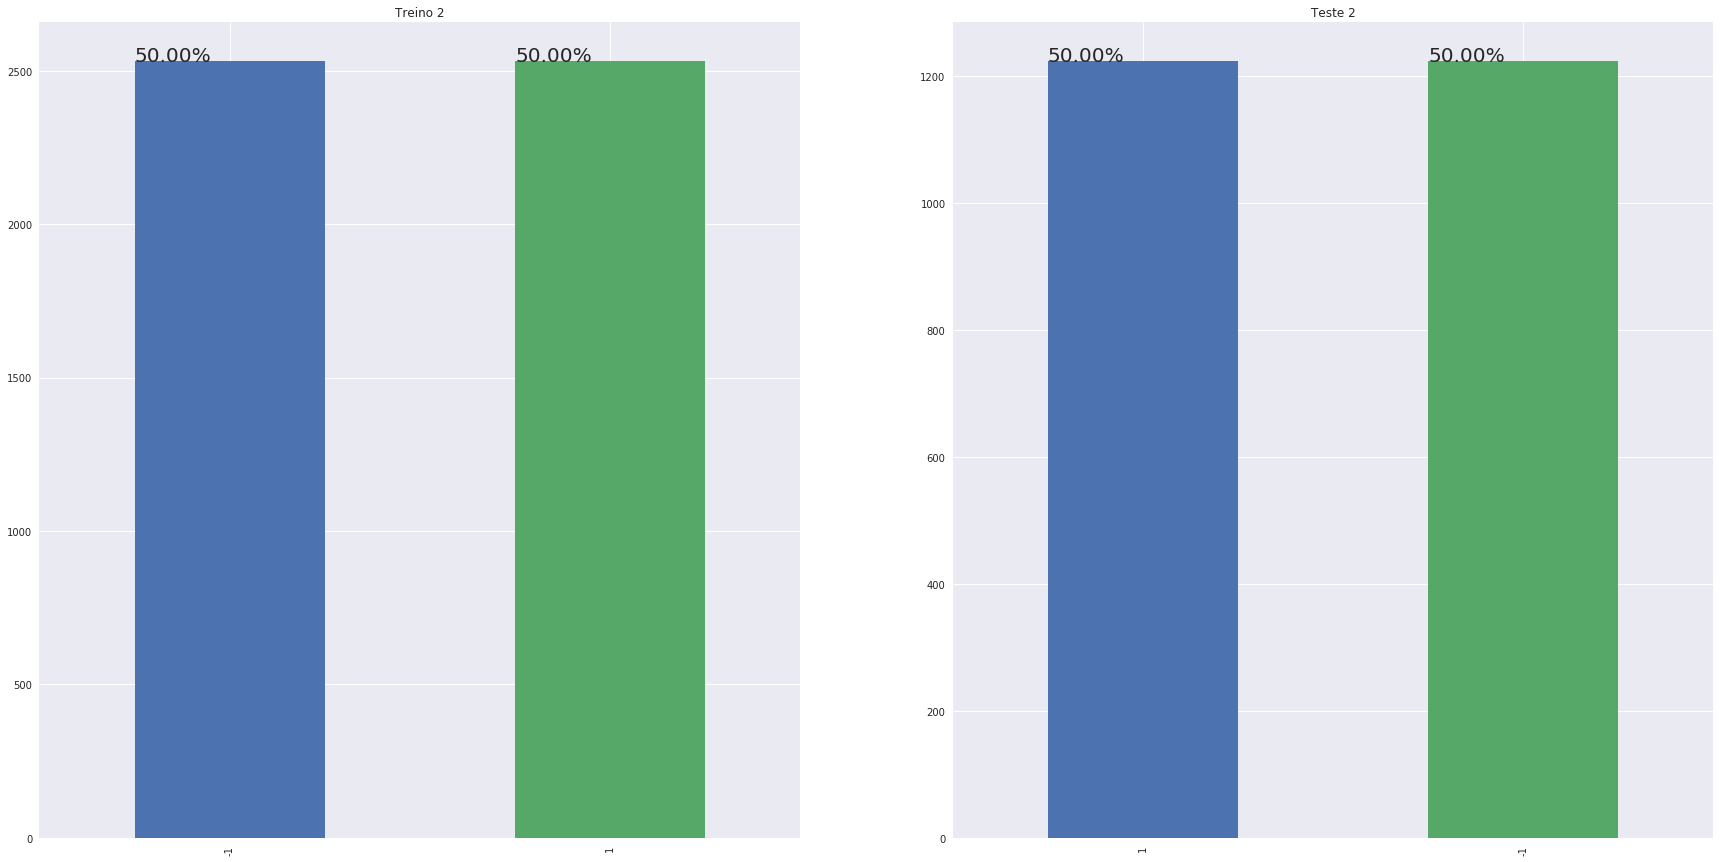

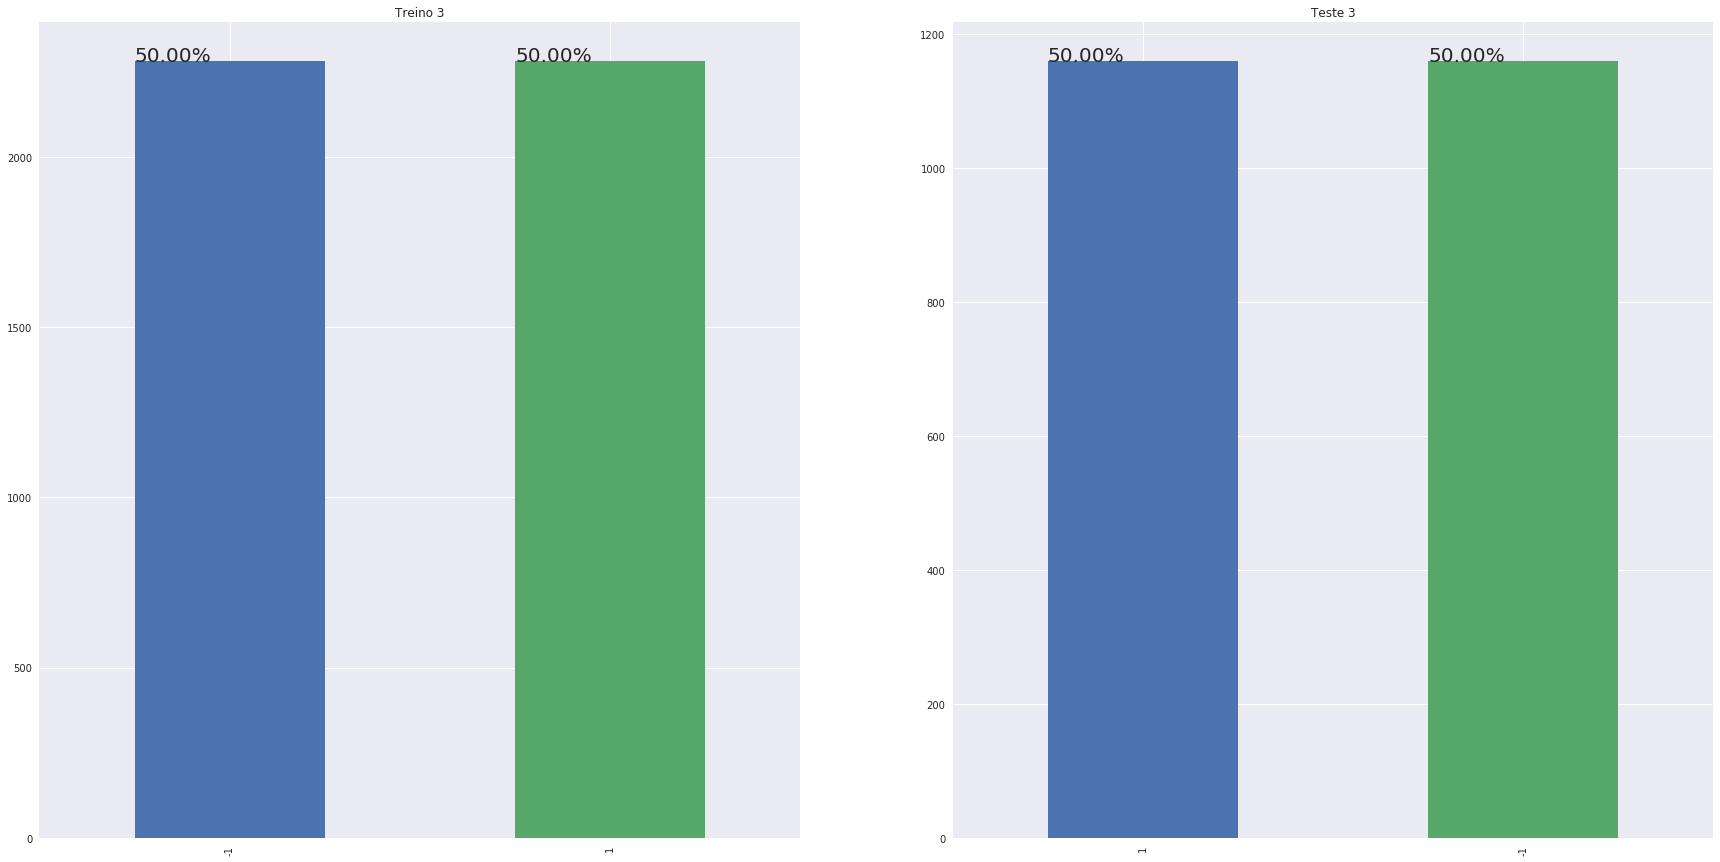

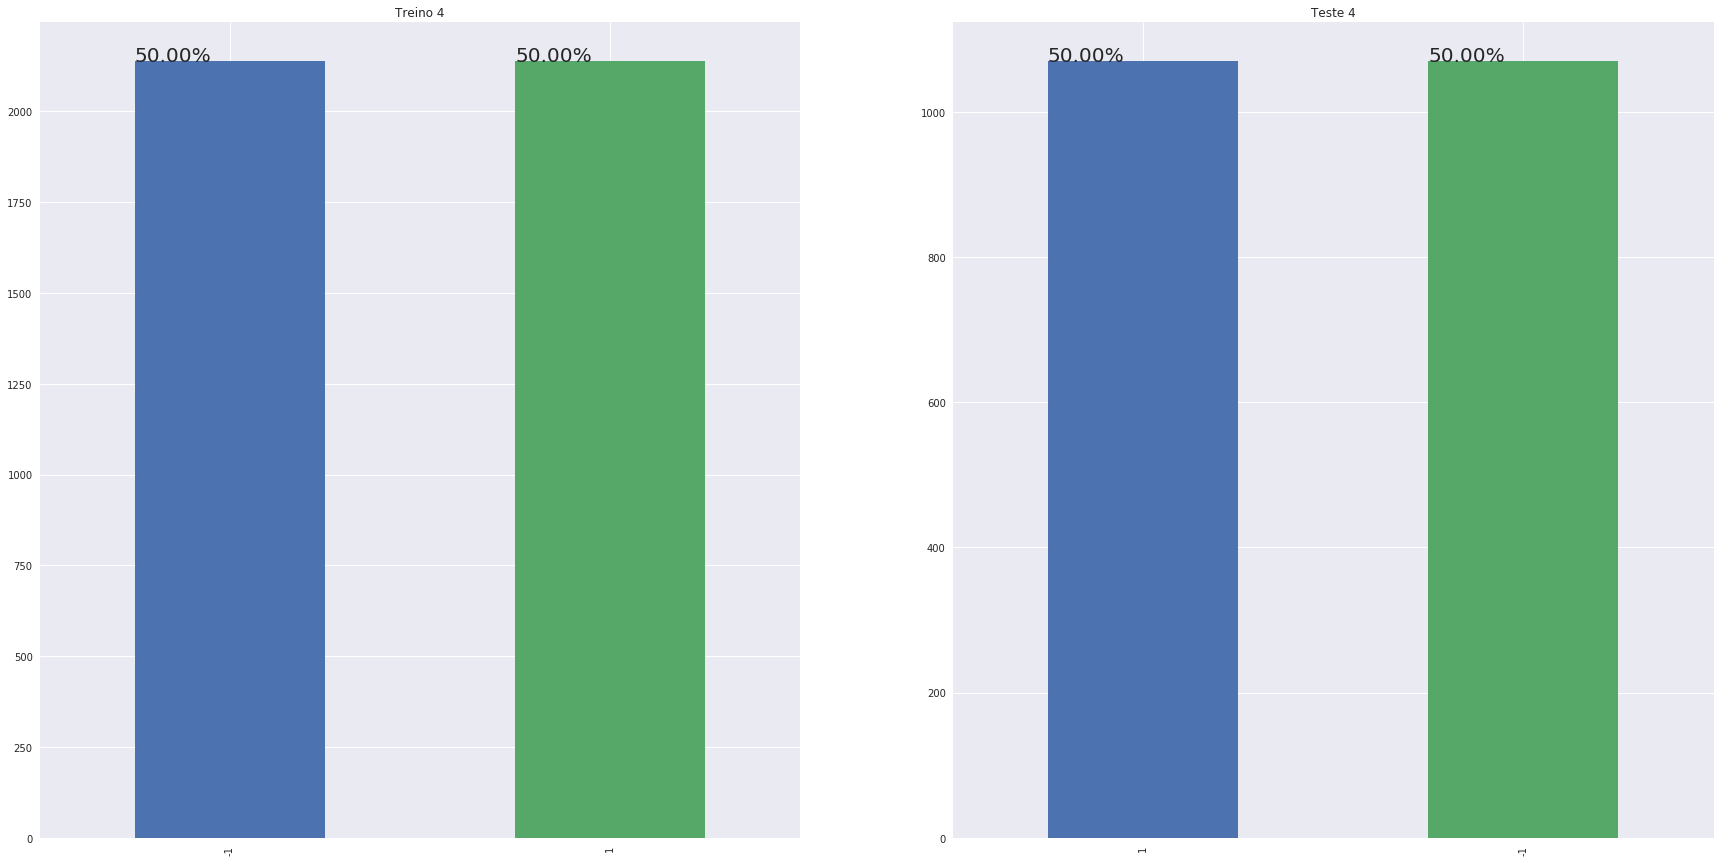

In [3]:
# Checando a distribuição dos targets em cada conjunto (treino e teste) de cada abordagem

sns.set(style='darkgrid')
temp_train = [train_target_1, train_target_2, train_target_3, train_target_4]
temp_test = [test_target_1, test_target_2, test_target_3, test_target_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

temp_train_b = [train_target_b_1, train_target_b_2, train_target_b_3, train_target_b_4]
temp_test_b = [test_target_b_1, test_target_b_2, test_target_b_3, test_target_b_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train_b[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test_b[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

In [4]:
# Importando módulos da regressão logística

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear', fit_intercept=False)

# logit = LogisticRegression(solver='liblinear', fit_intercept = False, C = 10**-4, penalty = 'l2')

# Definindo os parâmetros do modelo e possíveis valores

# param_grid = {'random_state': list(np.random.randint(100000, size=100))}

param_grid = {'penalty': ['l2', 'l1'], 
              'C': np.logspace(start=-7, stop=7, num=15, base=2)}

# Validação cruzada com cada conjunto de parâmetros

clf_logit = GridSearchCV(logit,param_grid,return_train_score=True,cv=10, 
                   scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision'], refit=False)

In [6]:
# Abordagem 1: Retirar valores faltantes e manter outliers

path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit.fit(pd.get_dummies(train_data_1), train_target_1)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_logit.fit(pd.get_dummies(train_data_b_1), train_target_b_1)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Regressao-logistica/regressao-logistica-abordagem-1-balanceado-dataset-10pct.pkl']

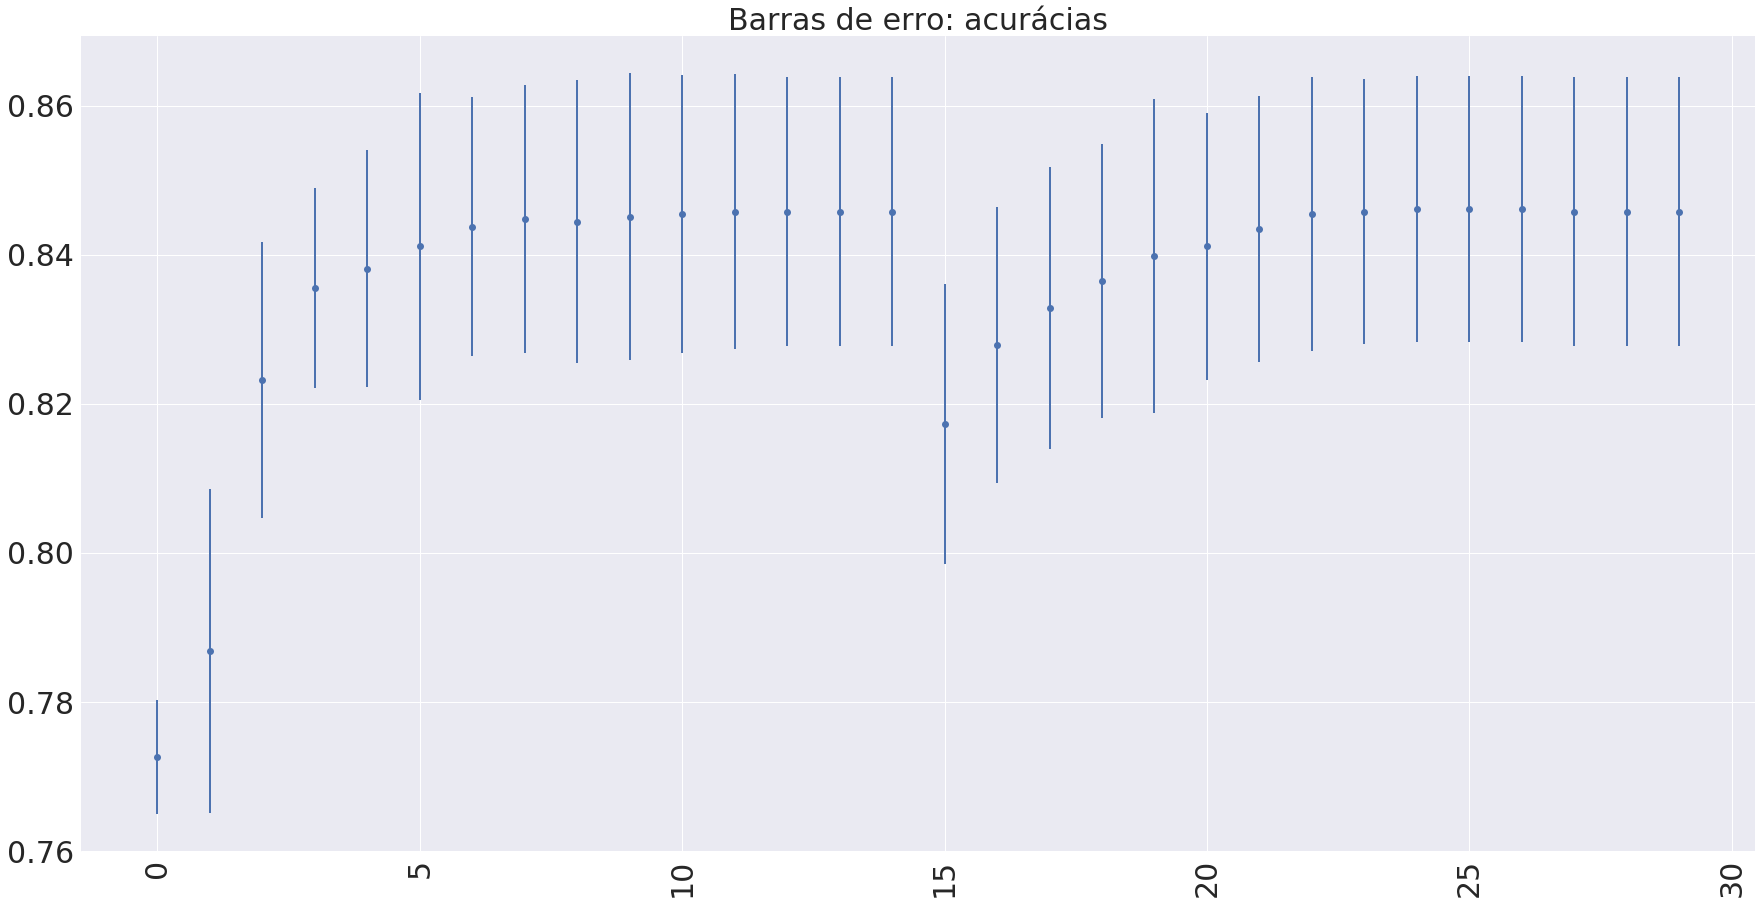

In [7]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit_desbalanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_desbalanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

# lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
    plt.show()

In [8]:
# n_max_depths = [10**x for x in np.linspace(start=-5, stop=9, num=15)]

# # print(list(range(int(results_test.shape[0]/2),results_test.shape[0])))

# for criterio in ['l1', 'l2']:
    
#     if criterio == 'l1':
#         range_cols = list(range(0,int(results_test.shape[0]/2)))
#     elif criterio == 'l2':
#         range_cols = list(range(int(results_test.shape[0]/2),results_test.shape[0]))
    
#     for metrica in lista_metricas:

#         results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
#         results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()

# #         results_test_filtered = results_test_filtered.iloc[:, 0:int((results_test_filtered.shape[1]/2))]
# #         results_train_filtered = results_train_filtered.iloc[:, 0:int((results_train_filtered.shape[1]/2))]

#         results_test_filtered = results_test_filtered.iloc[:, range_cols]
#         results_train_filtered = results_train_filtered.iloc[:, range_cols]
        
#         fig = plt.figure(figsize=(30,15))
#         plt.semilogx(n_max_depths, results_test_filtered.mean(), label='Validação', color='green', lw=2)
#         plt.fill_between(n_max_depths, results_test_filtered.mean() - results_test_filtered.std(),
#                      results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

#         plt.semilogx(n_max_depths, results_train_filtered.mean(), label='Treino', color='blue', lw=2)
#         plt.fill_between(n_max_depths, results_train_filtered.mean() - results_train_filtered.std(),
#                      results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
#         plt.title('Curvas de validação ('+ criterio + '): '+ metrica[1], fontsize=30)
#         plt.xticks(fontsize=30, rotation=90)
#         plt.xlabel('Número máximo de profundidade', fontsize=30)
#         plt.yticks(fontsize=30)
#         plt.legend(loc='best', fontsize=30)
#         plt.show()

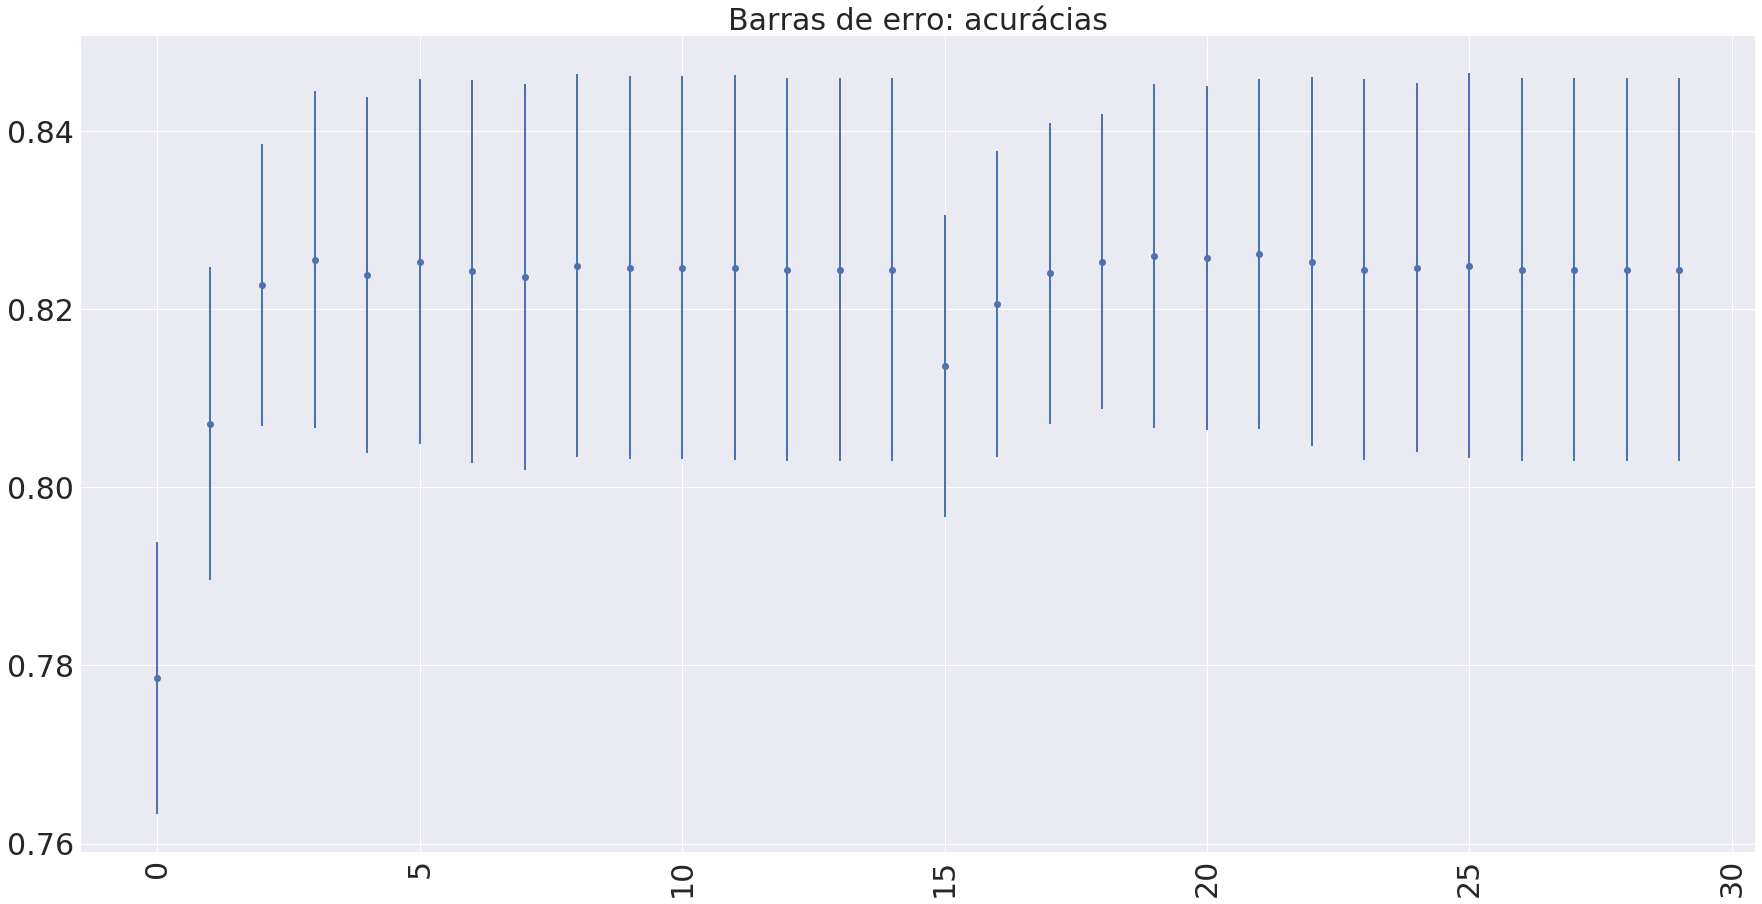

In [9]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit_balanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_balanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

# lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [10]:
# n_max_depths = [10**x for x in np.linspace(start=-5, stop=9, num=15)]

# # print(list(range(int(results_test.shape[0]/2),results_test.shape[0])))

# for criterio in ['l1', 'l2']:
    
#     if criterio == 'l1':
#         range_cols = list(range(0,int(results_test.shape[0]/2)))
#     elif criterio == 'l2':
#         range_cols = list(range(int(results_test.shape[0]/2),results_test.shape[0]))
    
#     for metrica in lista_metricas:

#         results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
#         results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()

# #         results_test_filtered = results_test_filtered.iloc[:, 0:int((results_test_filtered.shape[1]/2))]
# #         results_train_filtered = results_train_filtered.iloc[:, 0:int((results_train_filtered.shape[1]/2))]

#         results_test_filtered = results_test_filtered.iloc[:, range_cols]
#         results_train_filtered = results_train_filtered.iloc[:, range_cols]
        
#         fig = plt.figure(figsize=(30,15))
#         plt.semilogx(n_max_depths, results_test_filtered.mean(), label='Validação', color='green', lw=2)
#         plt.fill_between(n_max_depths, results_test_filtered.mean() - results_test_filtered.std(),
#                      results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

#         plt.semilogx(n_max_depths, results_train_filtered.mean(), label='Treino', color='blue', lw=2)
#         plt.fill_between(n_max_depths, results_train_filtered.mean() - results_train_filtered.std(),
#                      results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
#         plt.title('Curvas de validação ('+ criterio + '): '+ metrica[1], fontsize=30)
#         plt.xticks(fontsize=30, rotation=90)
#         plt.xlabel('Número máximo de profundidade', fontsize=30)
#         plt.yticks(fontsize=30)
#         plt.legend(loc='best', fontsize=30)
#         plt.show()

In [11]:
# Abordagem 2: Imputar valores faltantes e manter outliers

path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit.fit(pd.get_dummies(train_data_2), train_target_2)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_logit.fit(pd.get_dummies(train_data_b_2), train_target_b_2)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Regressao-logistica/regressao-logistica-abordagem-2-balanceado-dataset-10pct.pkl']

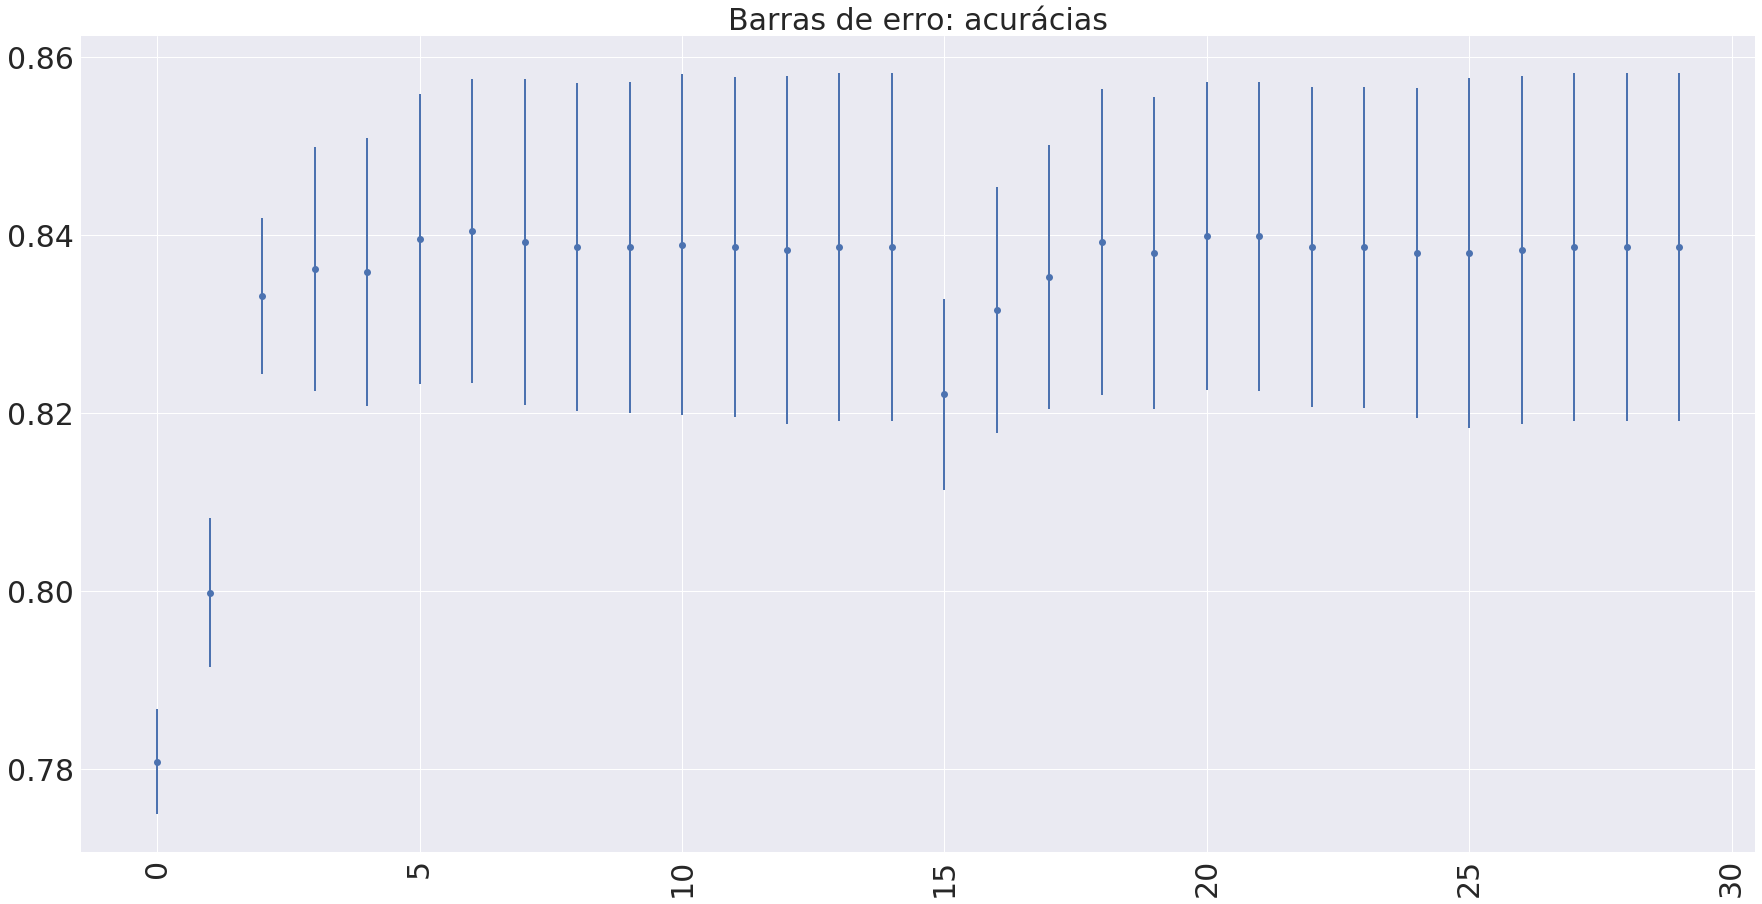

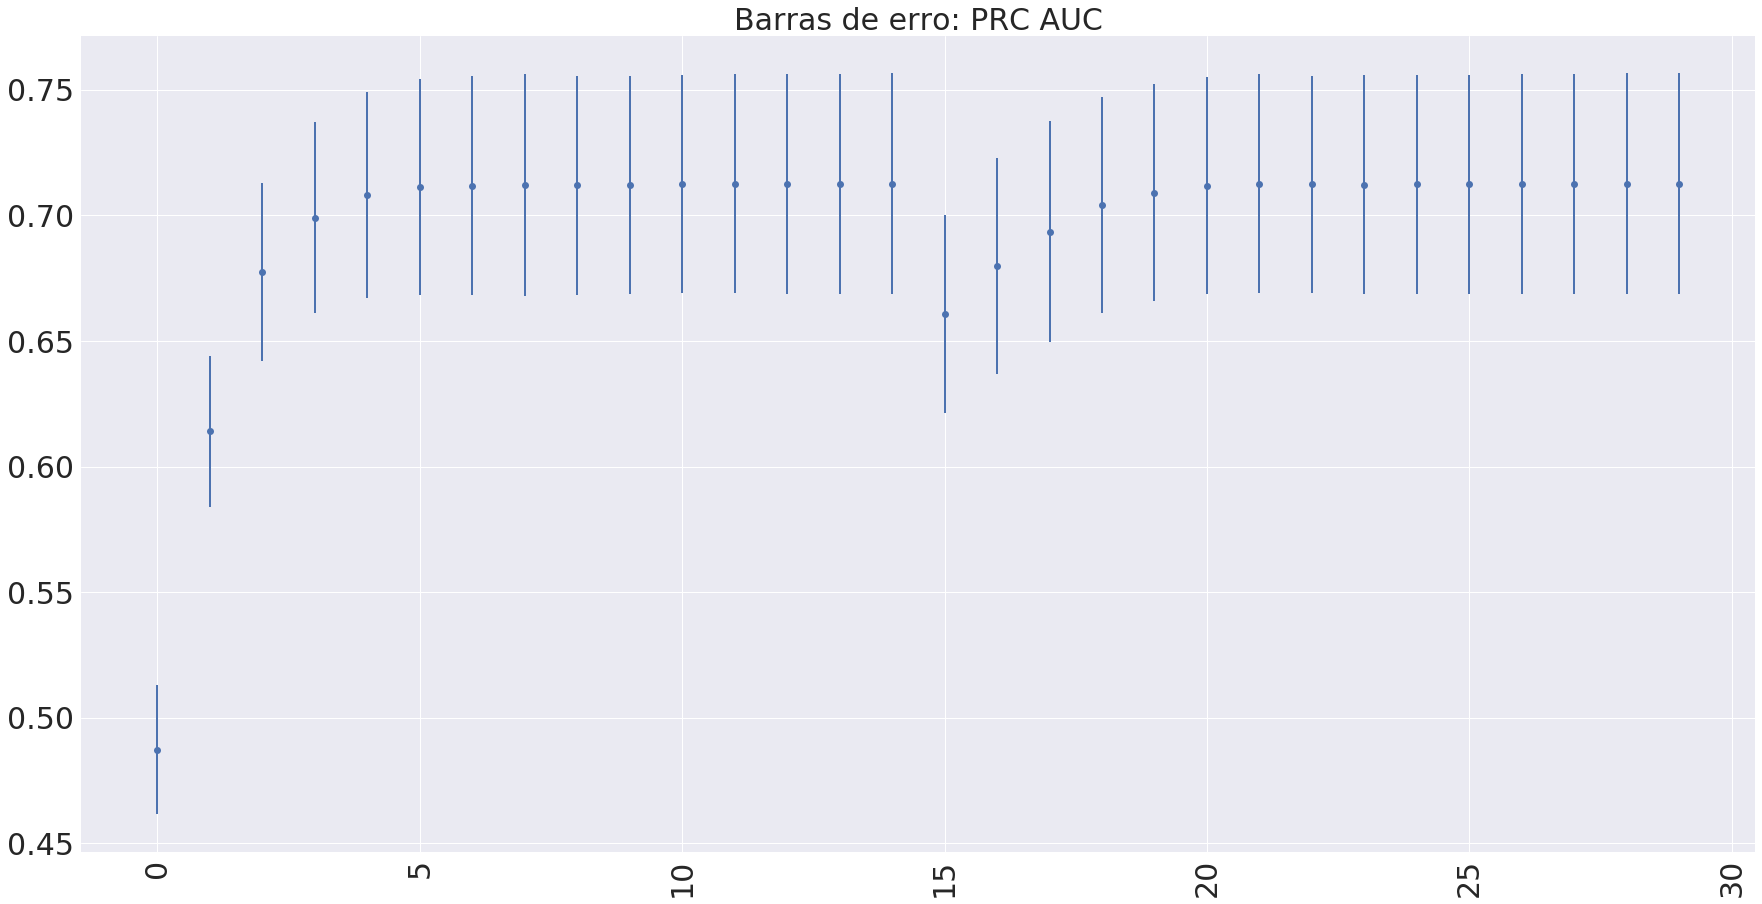

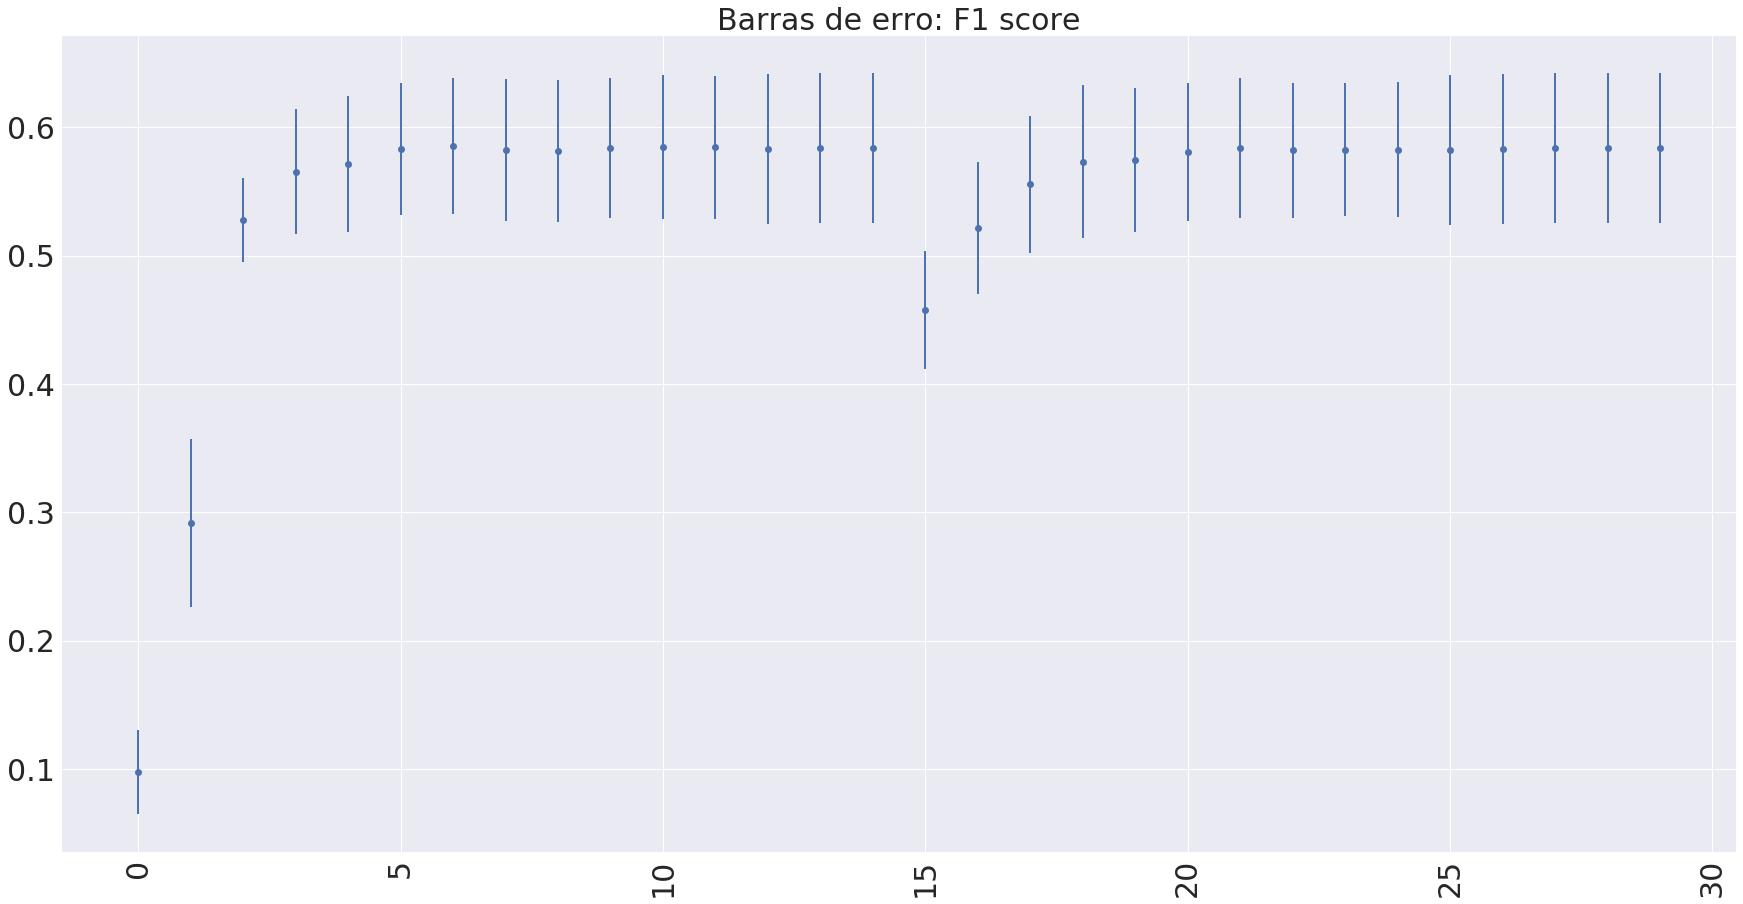

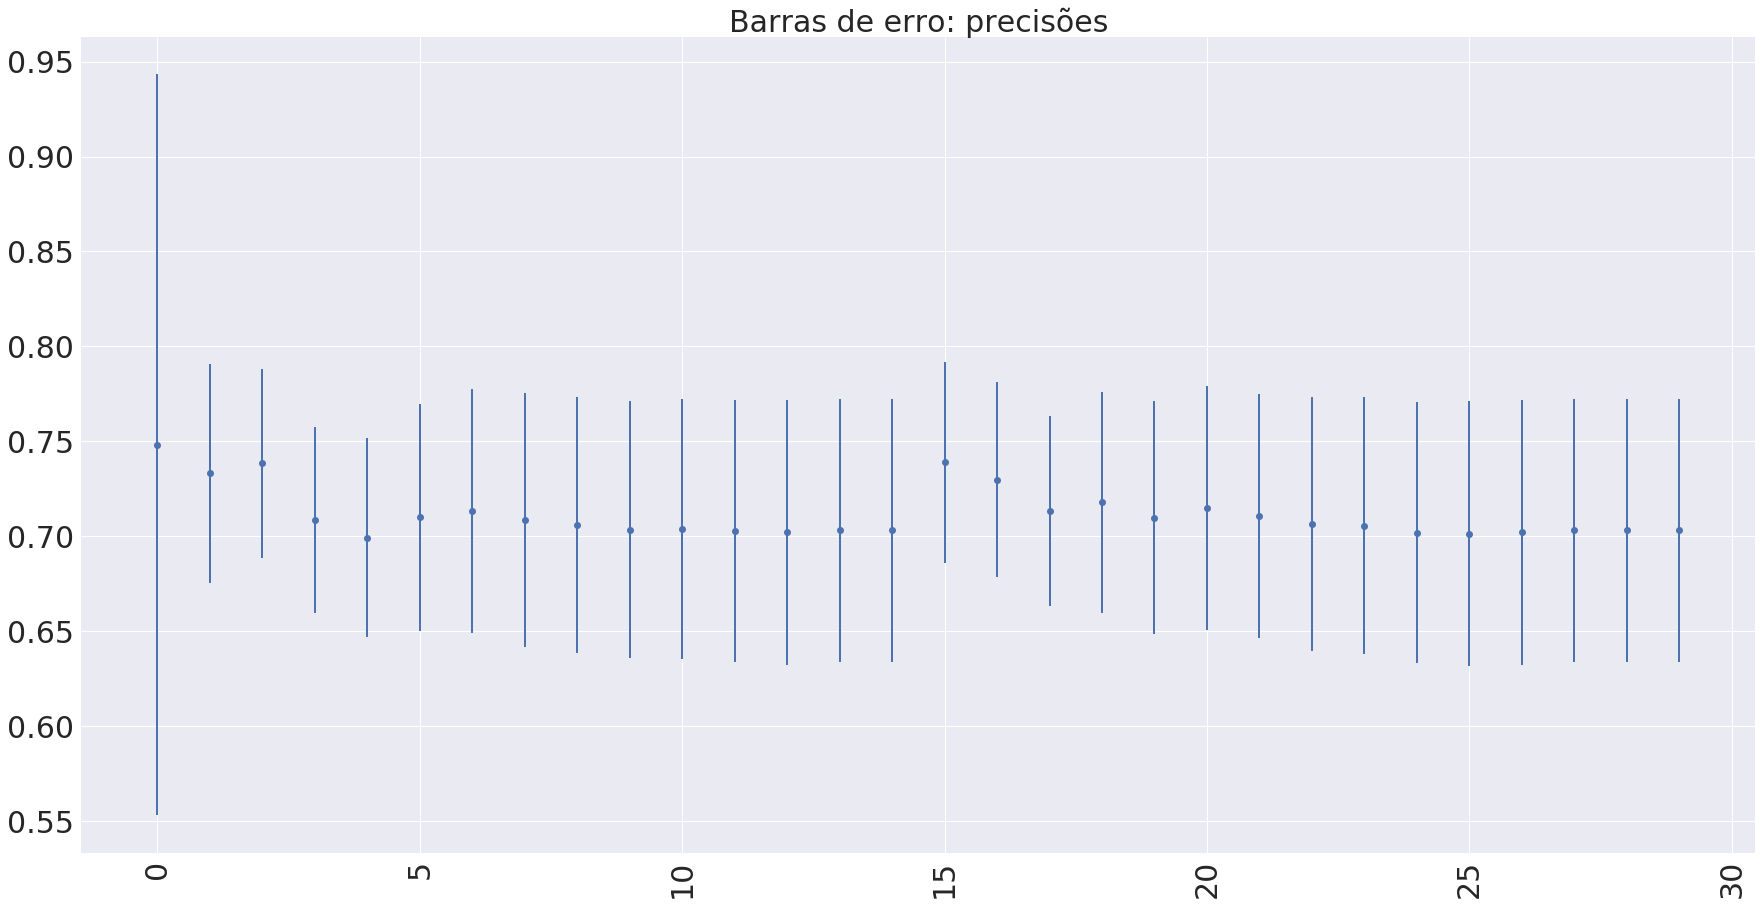

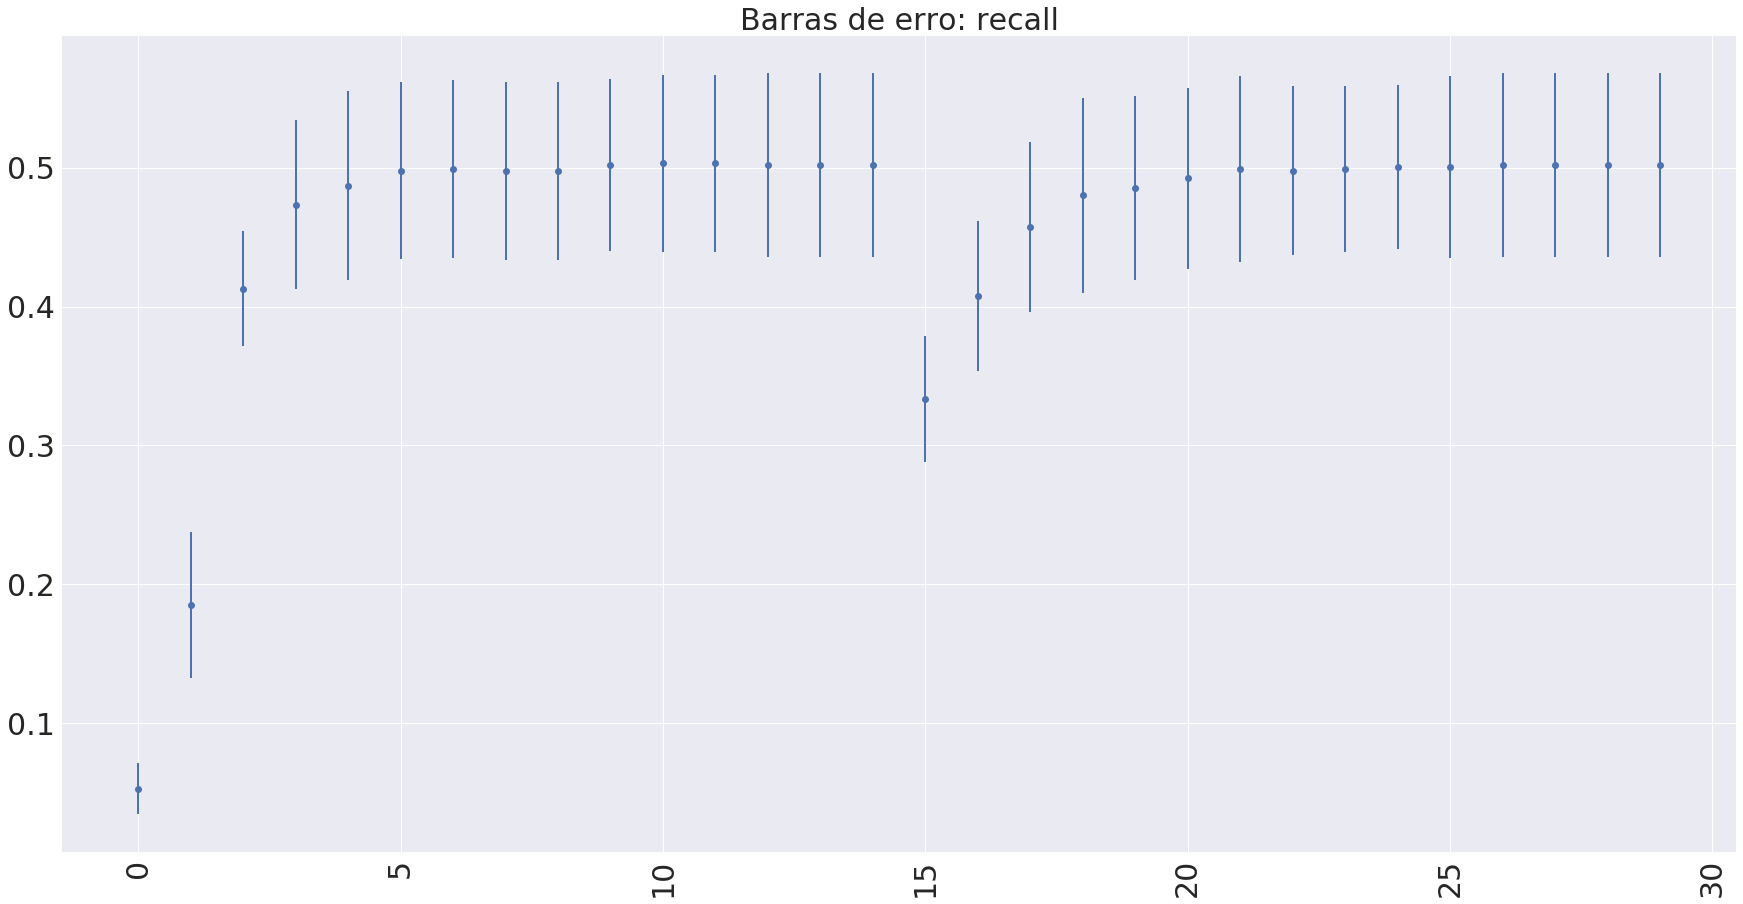

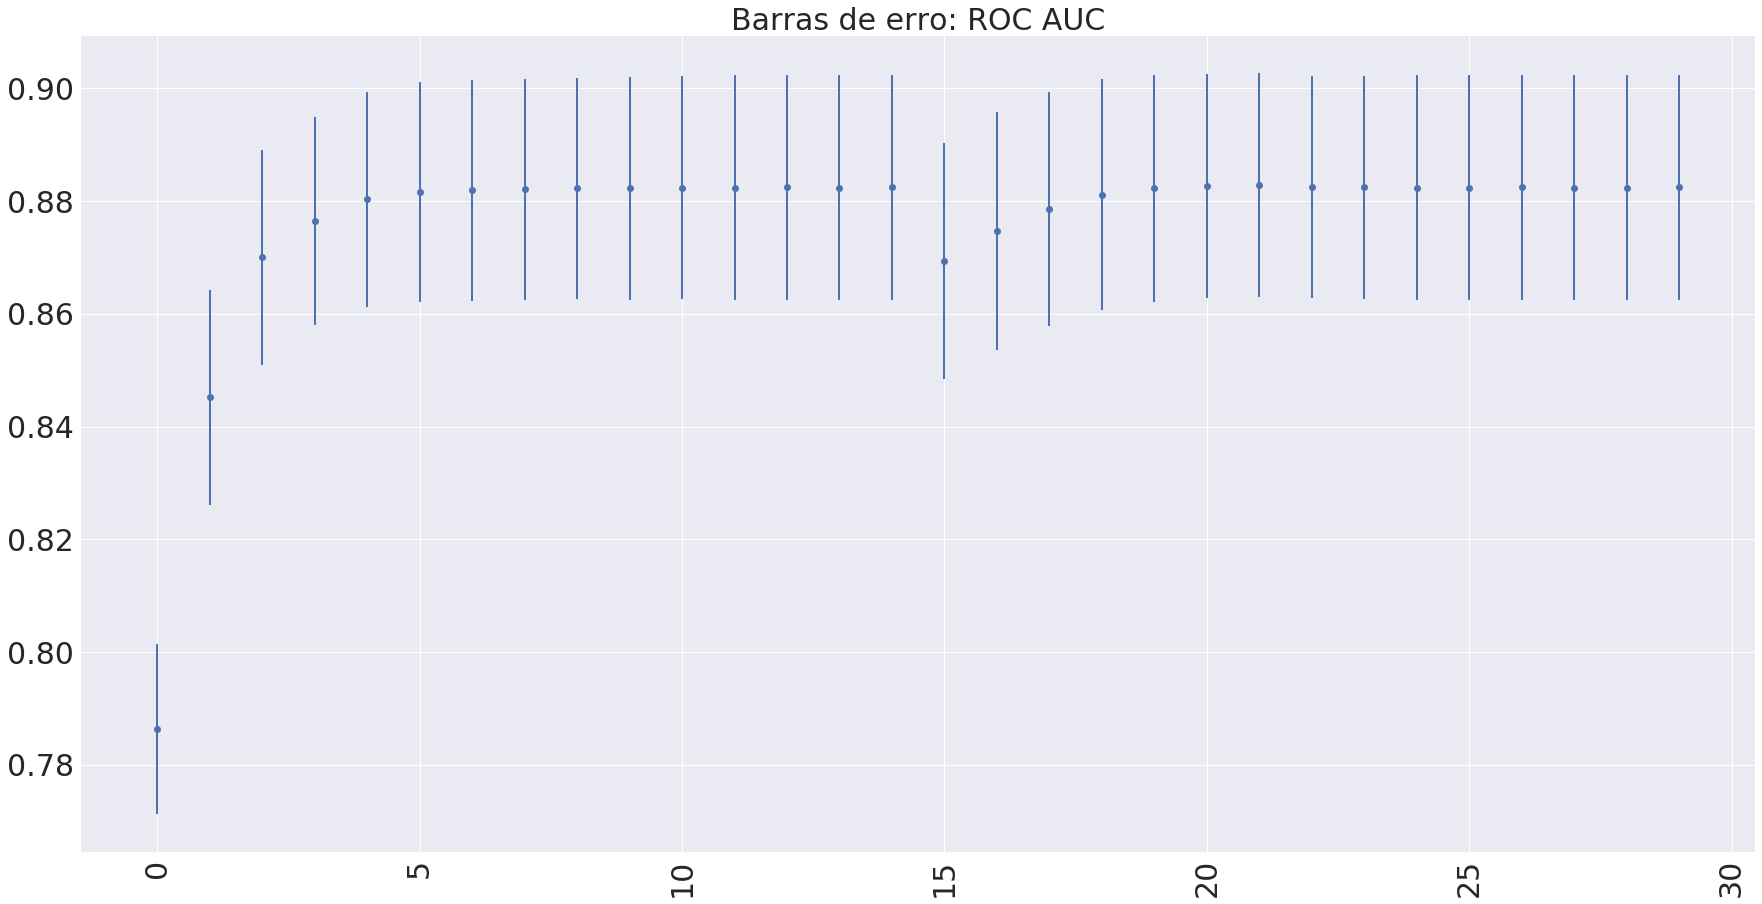

In [5]:
path_arquivos = 'Classificadores/Regressao-logistica/'
path_graficos = 'Classificadores/Regressao-logistica/graficos/'
str_balanceamento='desbalanceado'

clf_logit_desbalanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_desbalanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

# lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
#     filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-erros-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

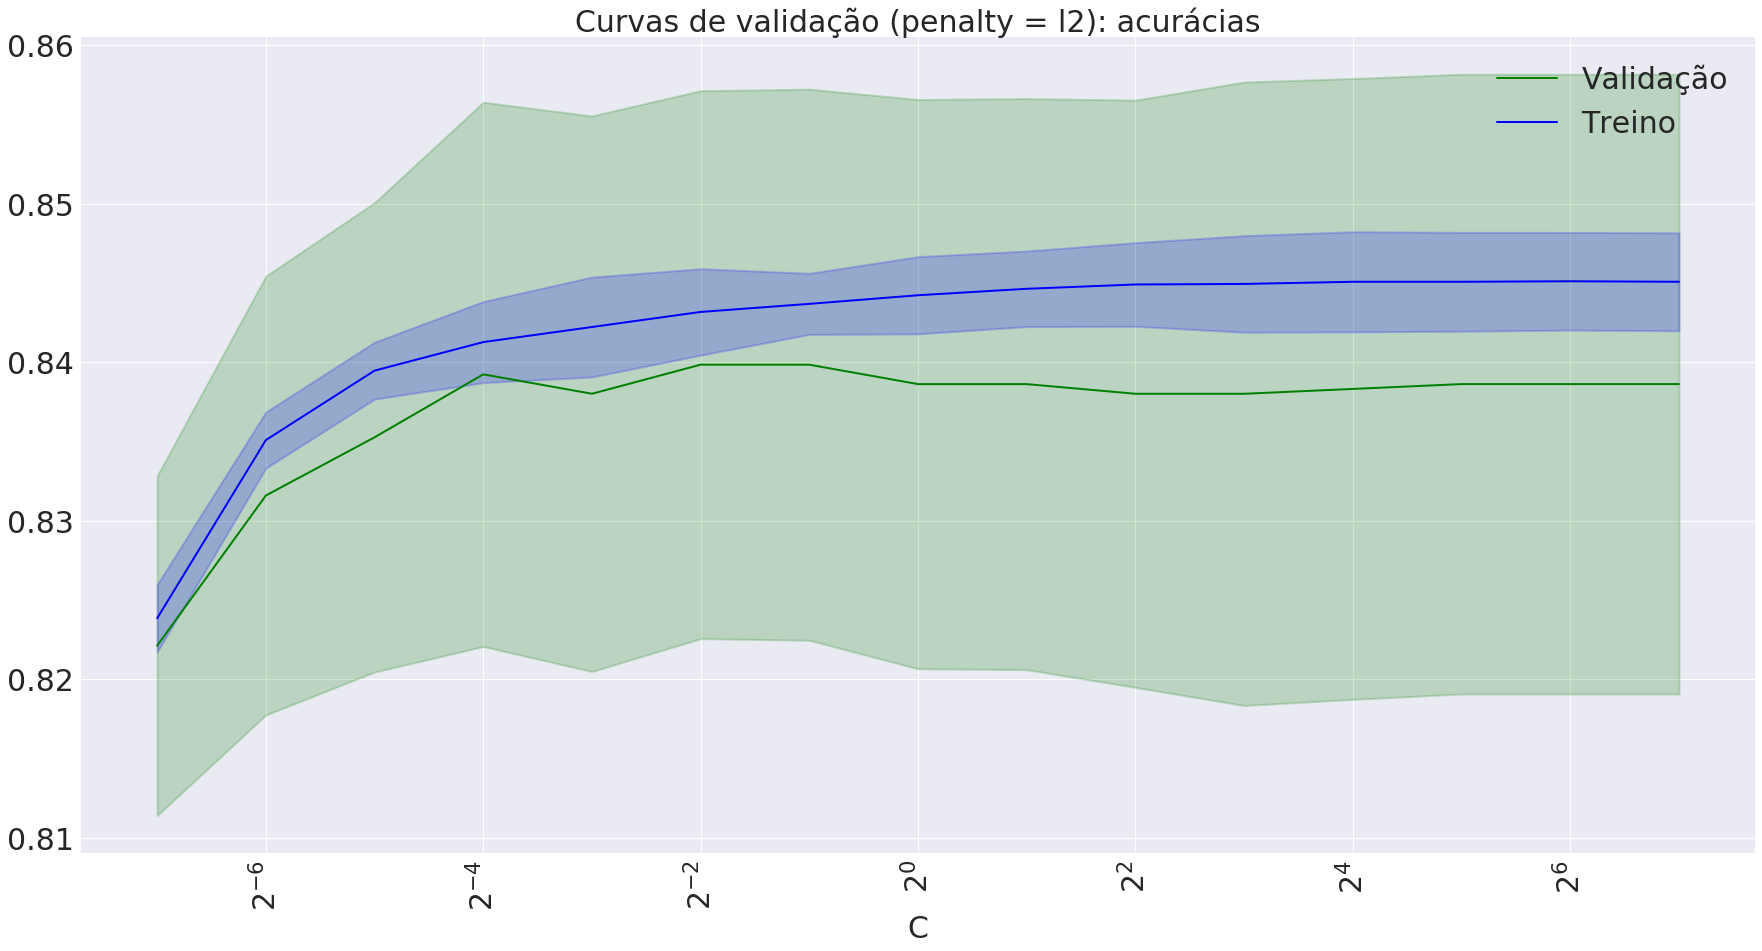

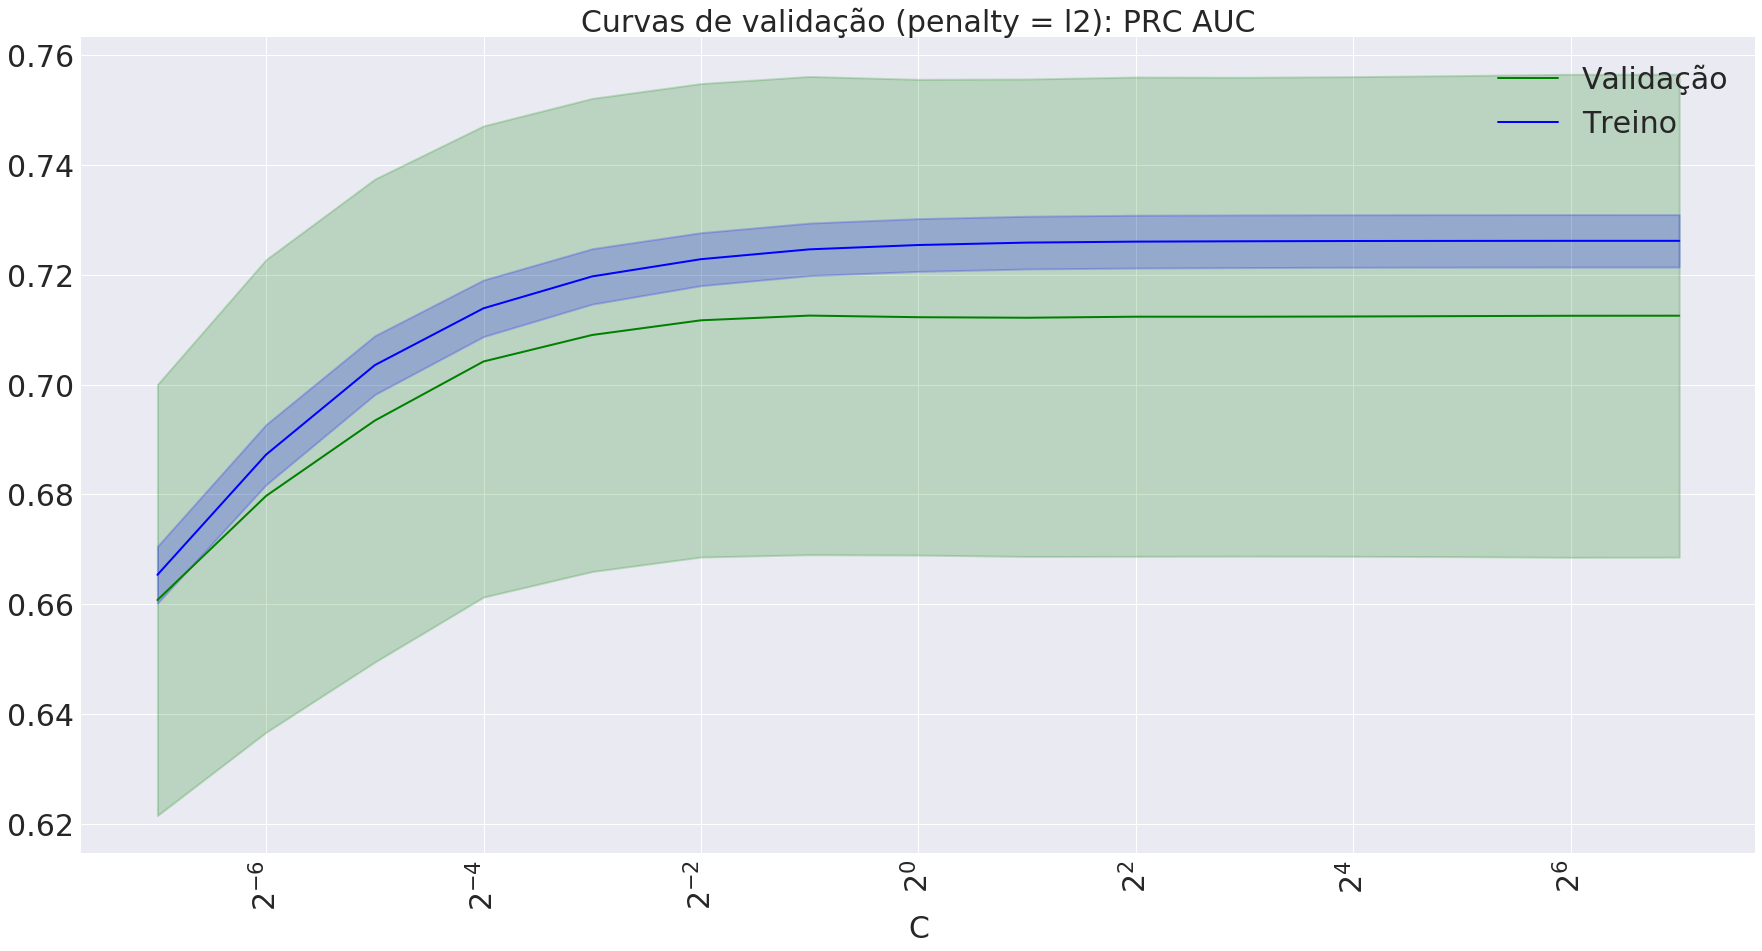

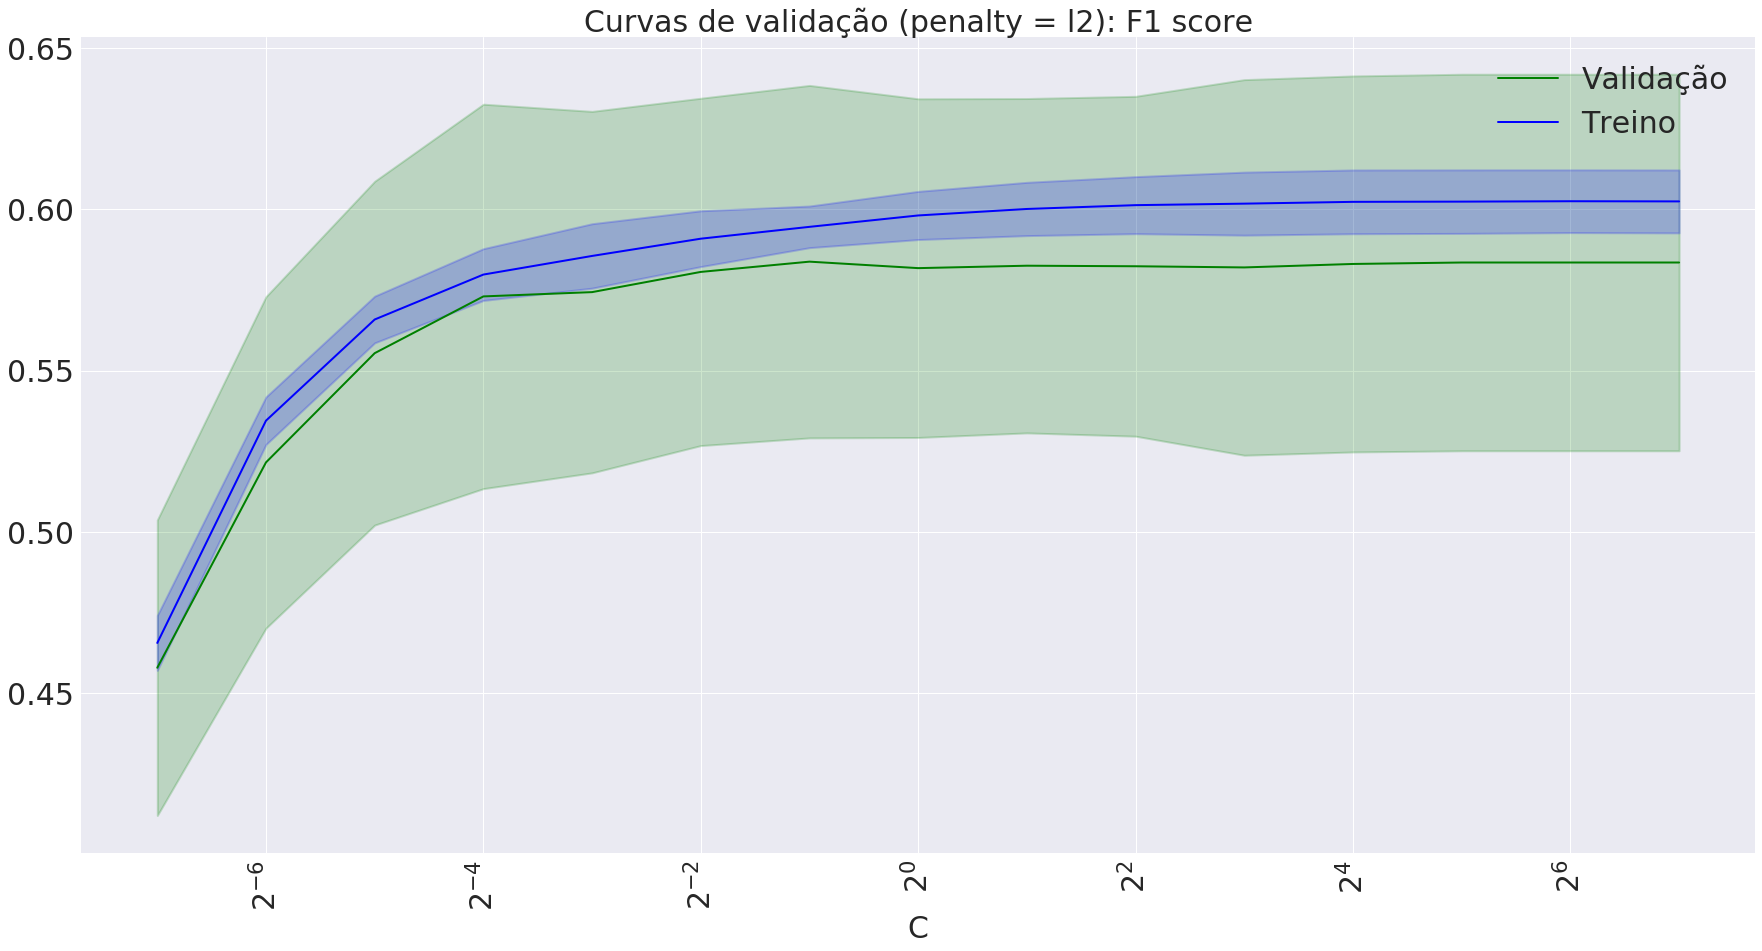

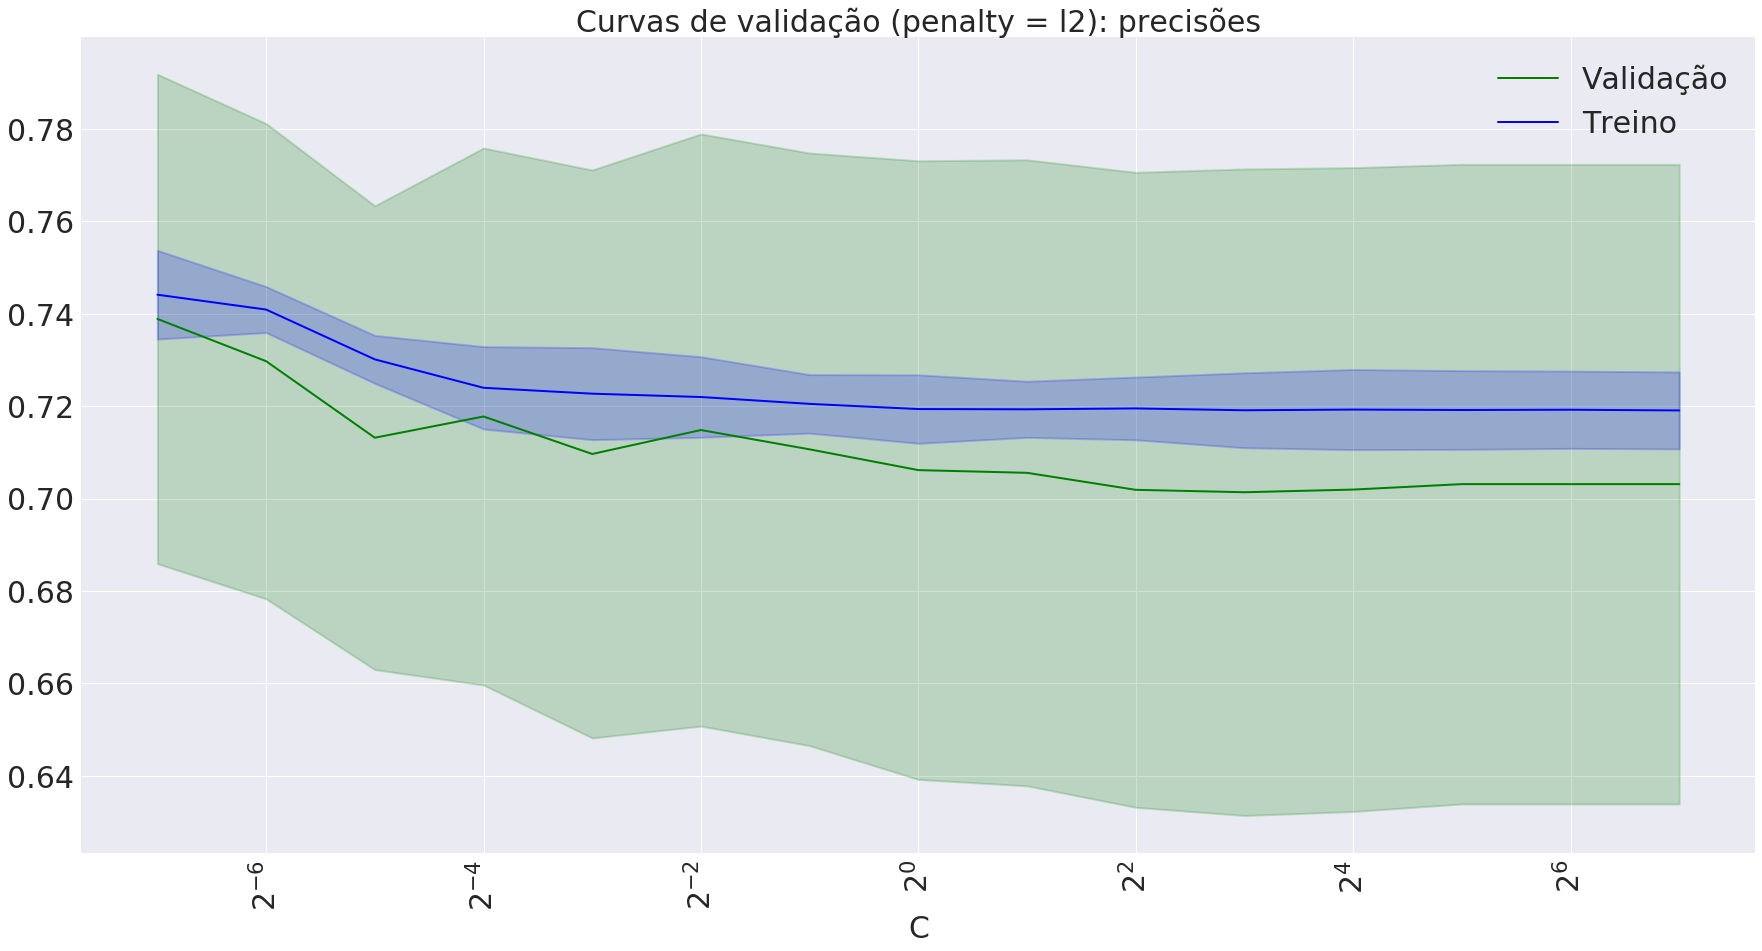

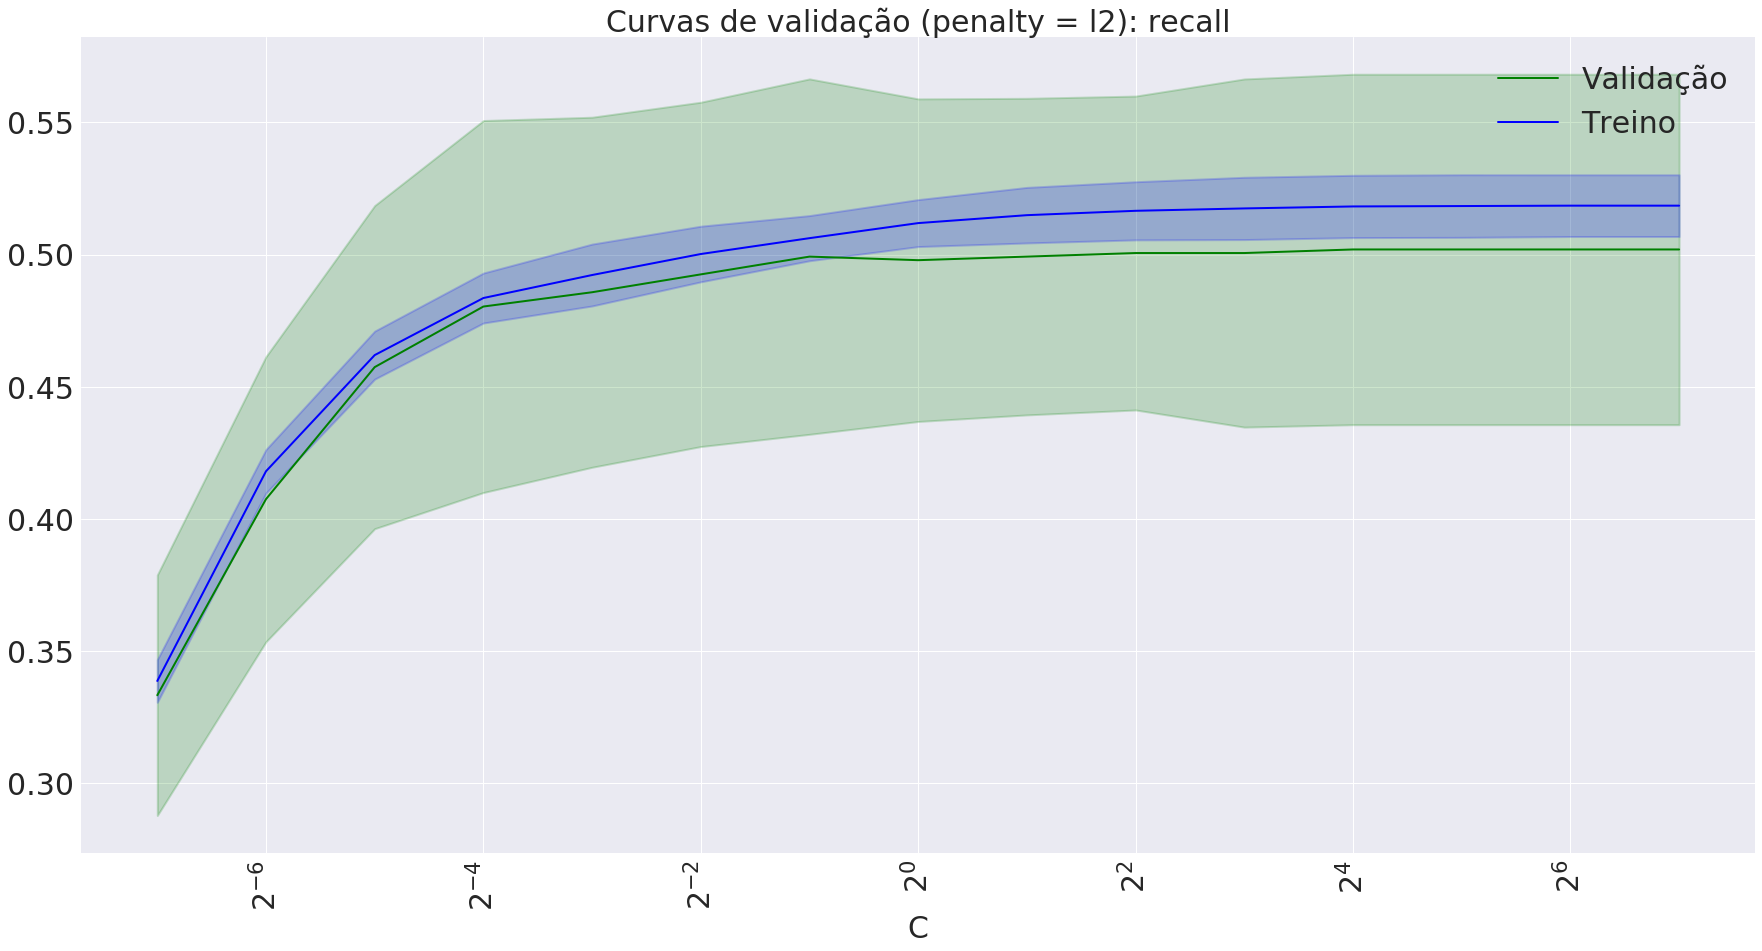

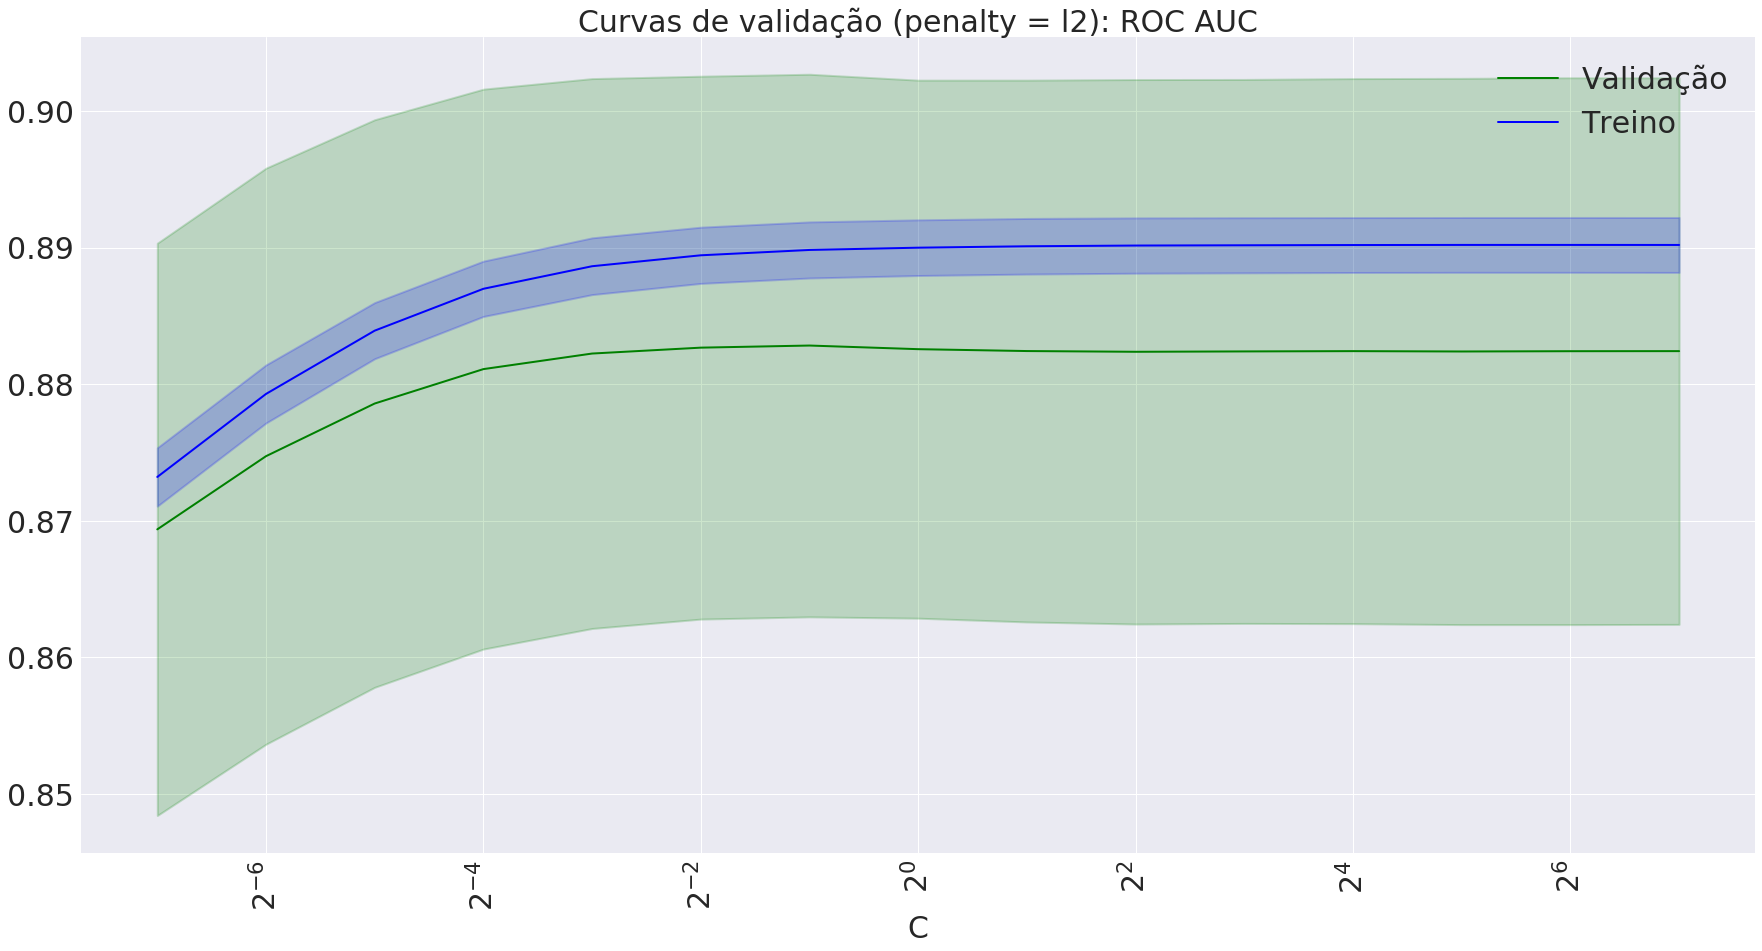

In [6]:
path_arquivos = 'Classificadores/Regressao-logistica/'
path_graficos = 'Classificadores/Regressao-logistica/graficos/'
str_balanceamento='desbalanceado'

C_step = 15
C_values = np.logspace(start=-7,stop=7,num=15,base=2)

# criterios = ['l2', 'l1']
criterios = ['l2']

for criterio in criterios:
    
    if criterio == 'l1':
        range_cols = list(range(0,int(results_test.shape[0]/2)))
    elif criterio == 'l2':
        range_cols = list(range(int(results_test.shape[0]/2),results_test.shape[0]))
    
    for metrica in lista_metricas:

        results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
        results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()
        
#         display(results_test_filtered.head(10))

#         results_test_filtered = results_test_filtered.iloc[:, 0:int((results_test_filtered.shape[1]/2))]
#         results_train_filtered = results_train_filtered.iloc[:, 0:int((results_train_filtered.shape[1]/2))]

        results_test_filtered = results_test_filtered.iloc[:, range_cols]
        results_train_filtered = results_train_filtered.iloc[:, range_cols]

        fig = plt.figure(figsize=(30,15))
        plt.semilogx(C_values, results_test_filtered.mean(), label='Validação', color='green', lw=2, basex=2)
        plt.fill_between(C_values, results_test_filtered.mean() - results_test_filtered.std(),
                     results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

        plt.semilogx(C_values, results_train_filtered.mean(), label='Treino', color='blue', lw=2, basex=2)
        plt.fill_between(C_values, results_train_filtered.mean() - results_train_filtered.std(),
                     results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
        plt.title('Curvas de validação (penalty = '+ criterio + '): '+ metrica[1], fontsize=30)
        plt.xticks(fontsize=30, rotation=90)
        plt.xlabel('C', fontsize=30)
        plt.yticks(fontsize=30)
        plt.legend(loc='best', fontsize=30)
        
        filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+str(metrica[0])+'.png'
        plt.savefig(path_graficos+filename_graficos)
        
        plt.show()

In [14]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit = LogisticRegression(solver = 'liblinear', fit_intercept = False, C = 1, penalty = 'l2')

clf_logit.fit(pd.get_dummies(train_data_2), train_target_2)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-final-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Regressao-logistica/regressao-logistica-final-abordagem-2-desbalanceado-dataset-10pct.pkl']

Acurácia: 84.677 %
Precisão: 75.269 %
Recall: 54.124 %
F1 score: 62.968516 %
ROC AUC: 89.557 %
PRC AUC: 74.916 %


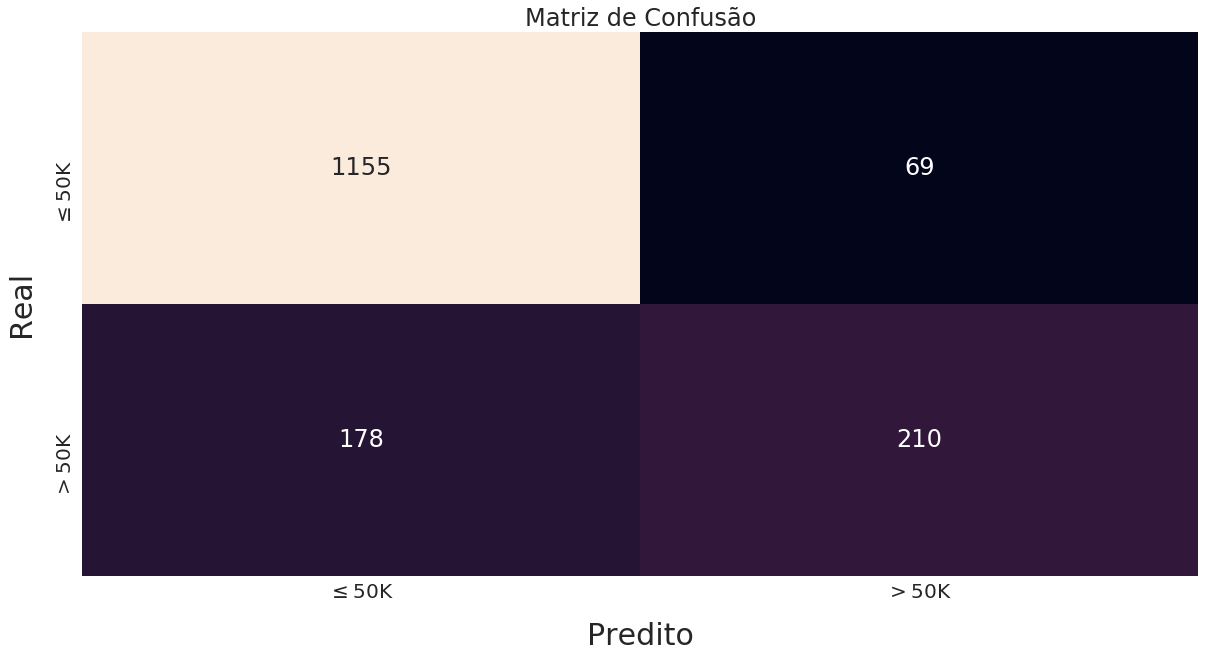

In [7]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_final_desbalanceado = joblib.load(path_arquivos+'regressao-logistica-final-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_final_desbalanceado, 
                         test_data=pd.get_dummies(test_data_2), 
                         test_target=test_target_2, 
                         id_abordagem=2, 
                         str_balanceamento='desbalanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='logit',
                         salvar_resultados=True)

In [ ]:
from sklearn.model_selection import learning_curve

path_arquivos = 'Classificadores/Regressao-logistica/'
path_graficos = 'Classificadores/Regressao-logistica/graficos/'
str_balanceamento='desbalanceado'

lista_metricas = [('accuracy', 'Acurácia'), ('precision', 'Precisão'), ('recall', 'Recall'), ('roc_auc', 'ROC AUC'), ('f1', 'F1 Score'), ('average_precision', 'PRC AUC')]

for metrica in lista_metricas:

    train_sizes, train_scores, test_scores = learning_curve(
            clf_final_desbalanceado, pd.get_dummies(train_data_2), train_target_2, cv=10, train_sizes=np.linspace(.1, 1.0, 50), 
            scoring=metrica[0])

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(30,15))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Validação")

    plt.ylabel(metrica[1], fontsize=30, labelpad=20)
    plt.xlabel('Tamanho Conjunto de Treino (amostras)', fontsize=30, labelpad=20)
    plt.title('Curvas de Aprendizado ('+str_balanceamento+')', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="best", fontsize=30)
    
    filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-curvas_aprendizado-'+str(metrica[0])+'.png'
    plt.savefig(path_graficos+filename_graficos)

    plt.show()

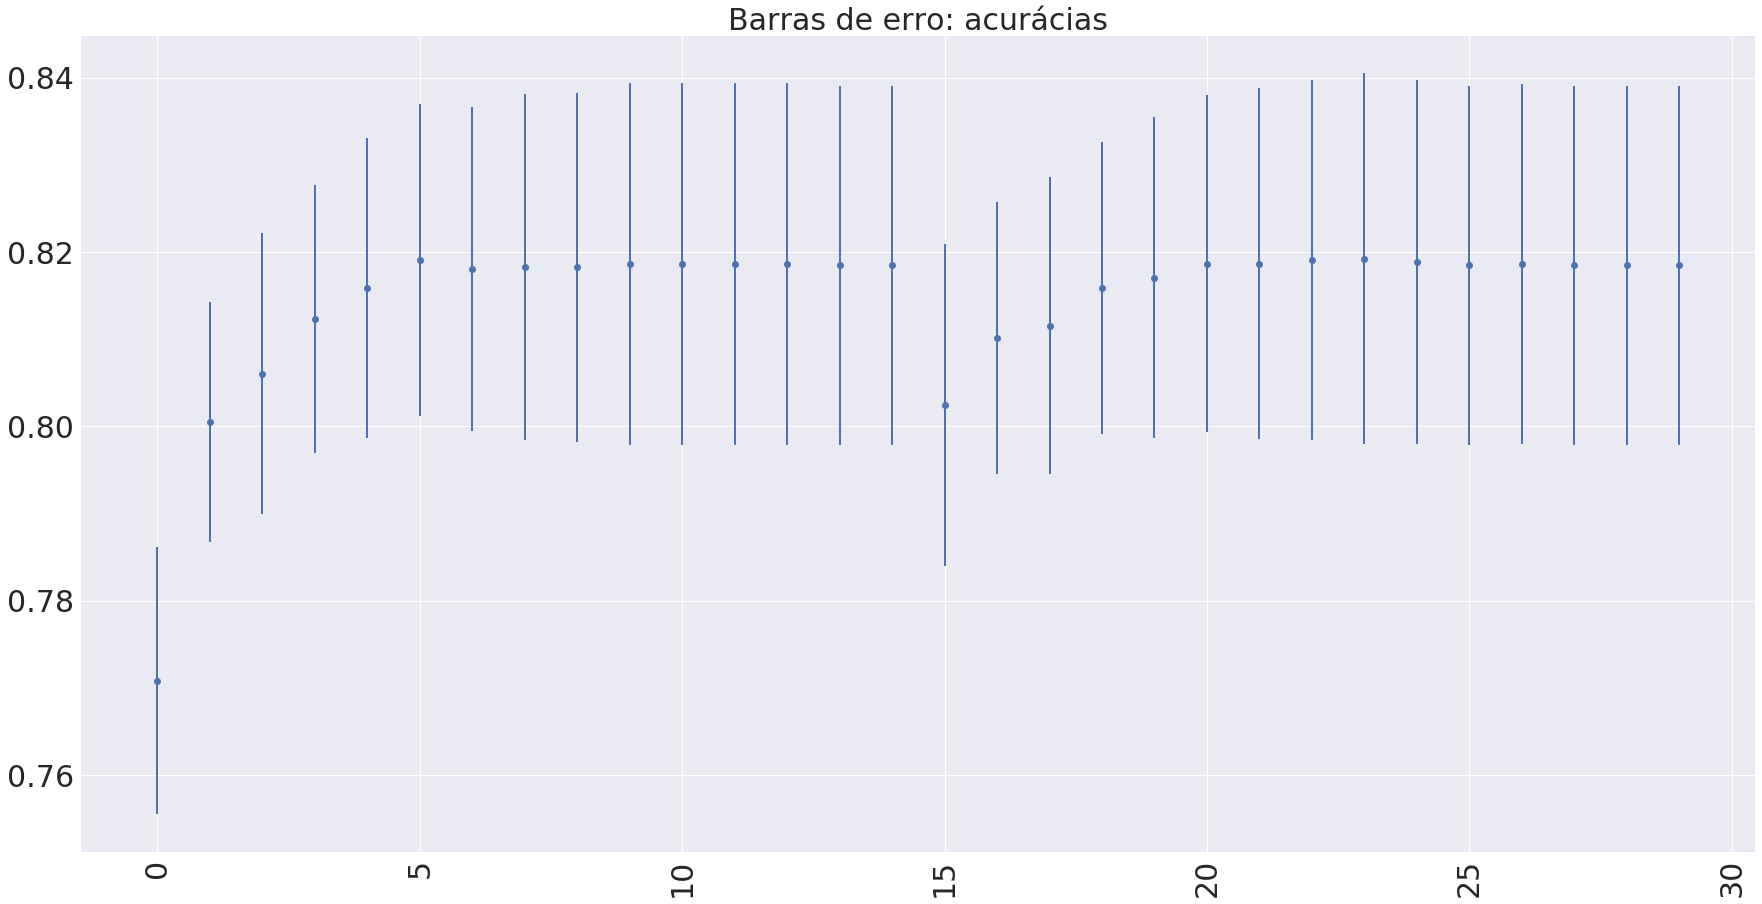

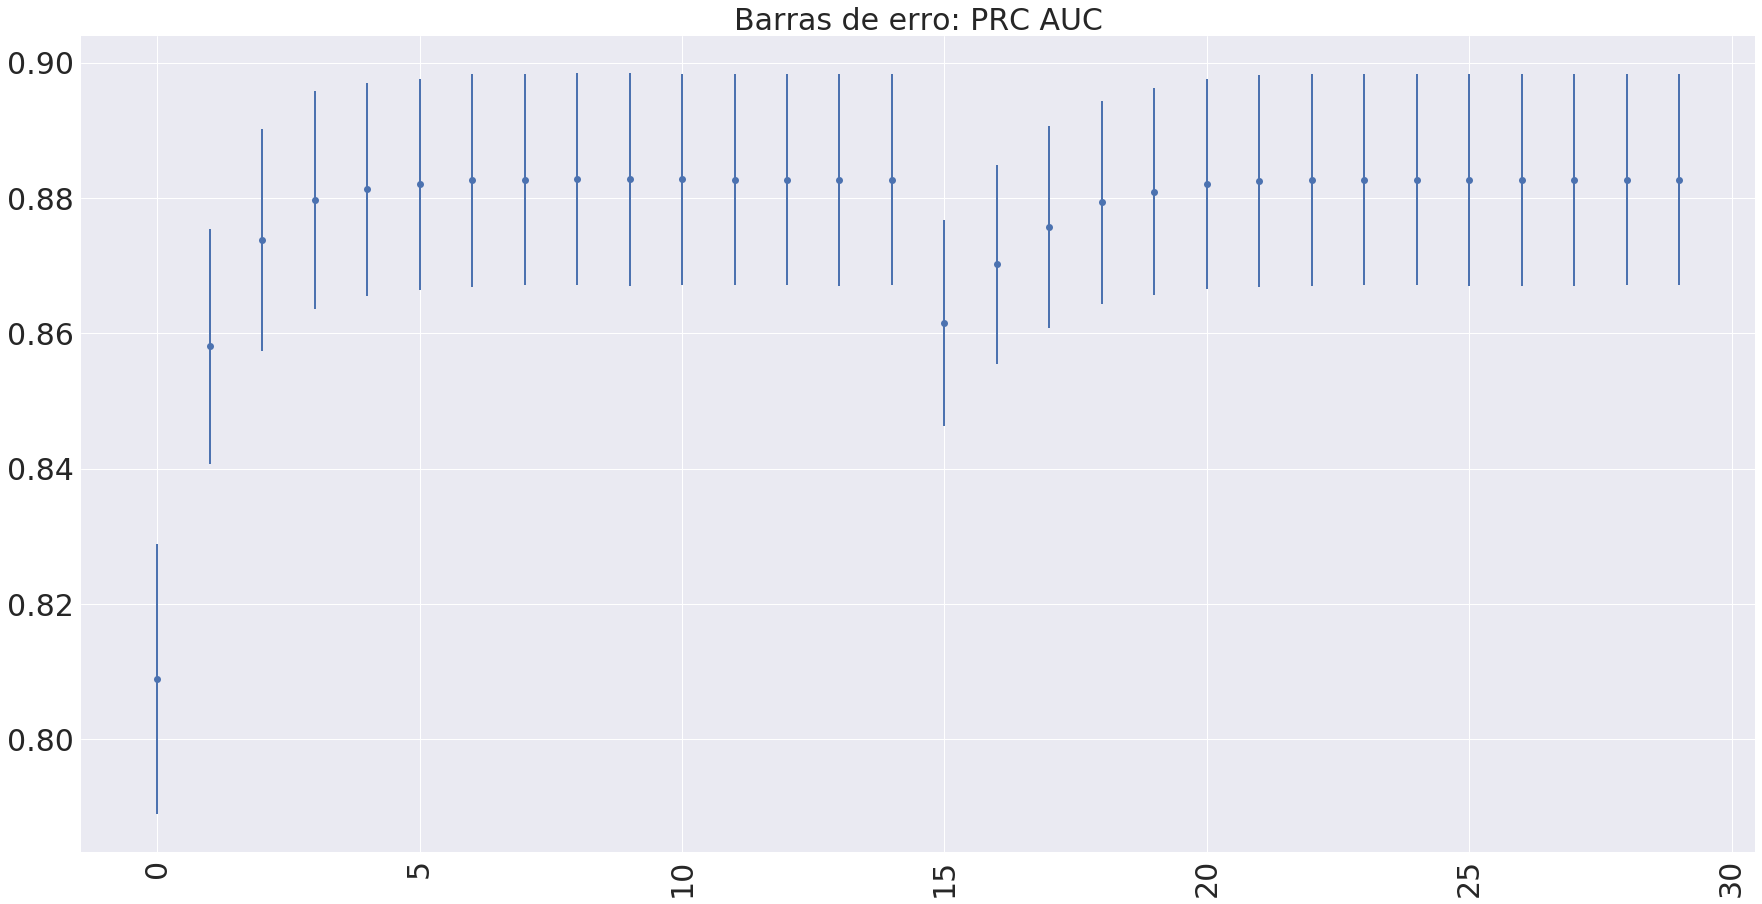

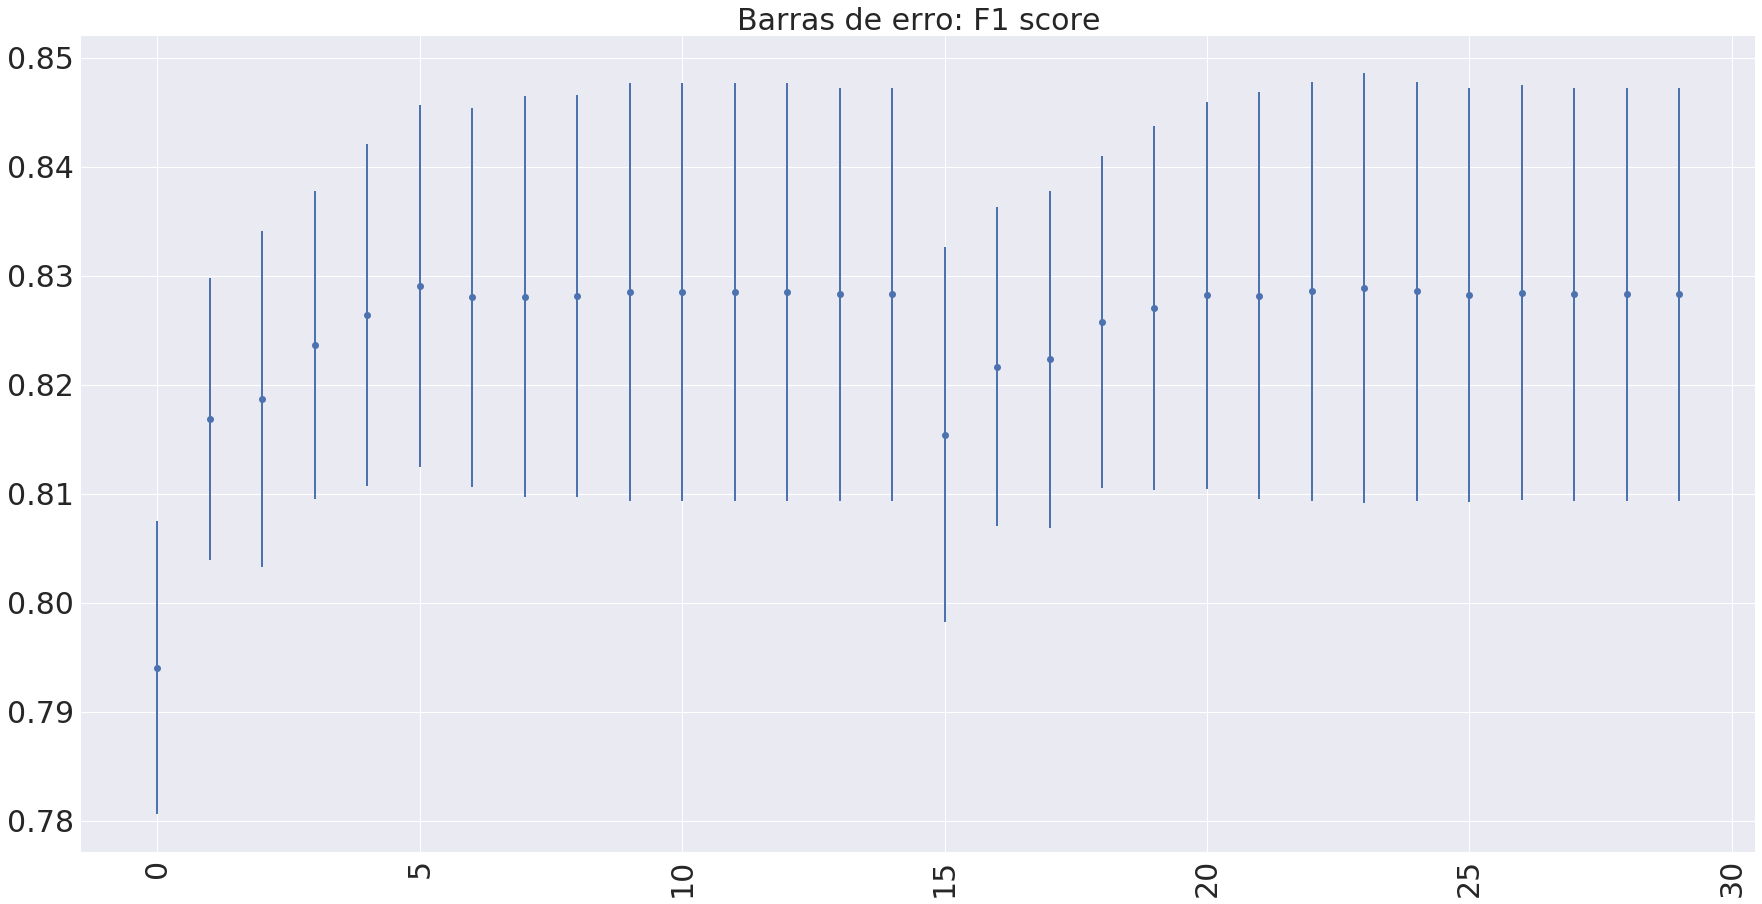

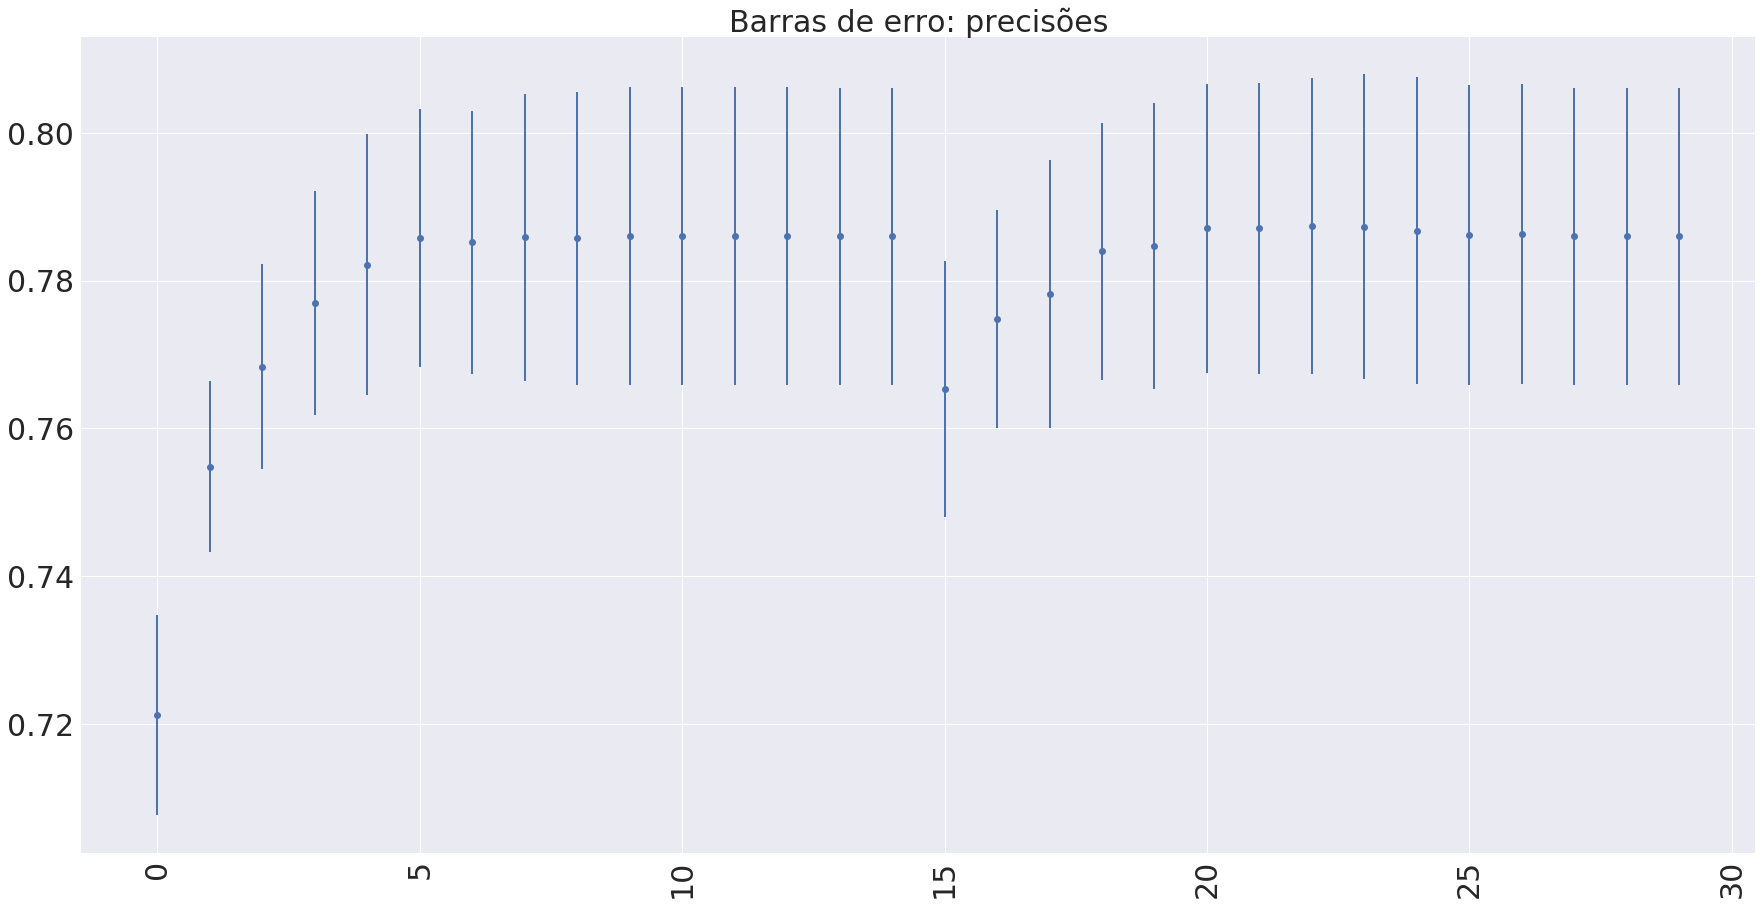

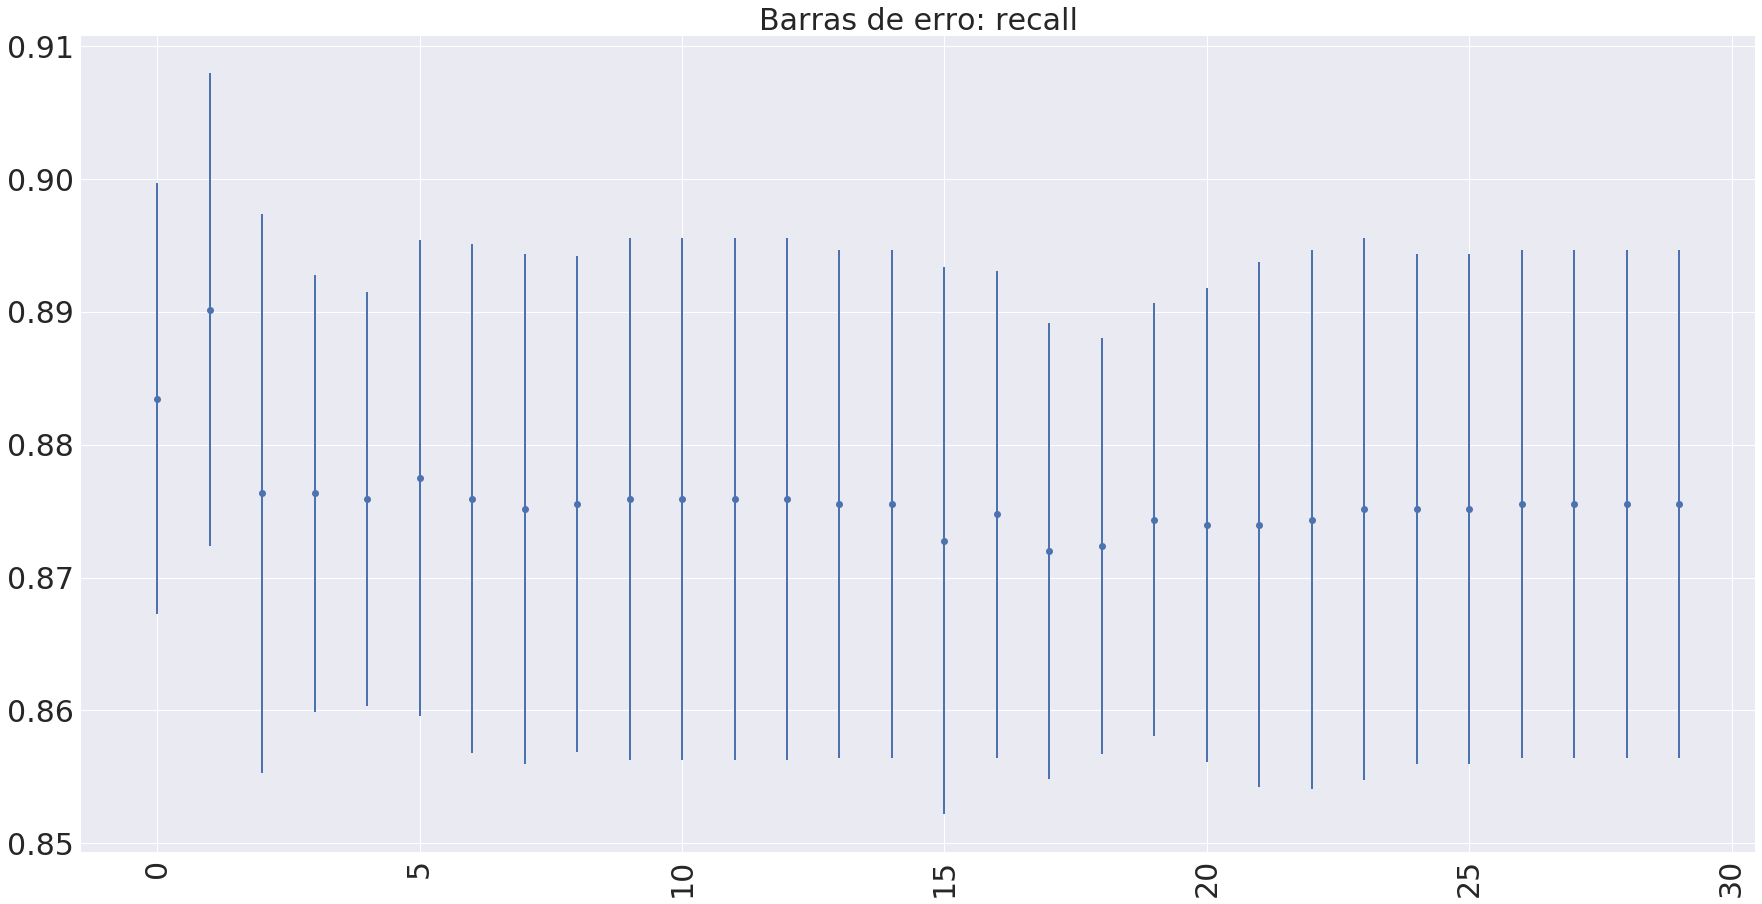

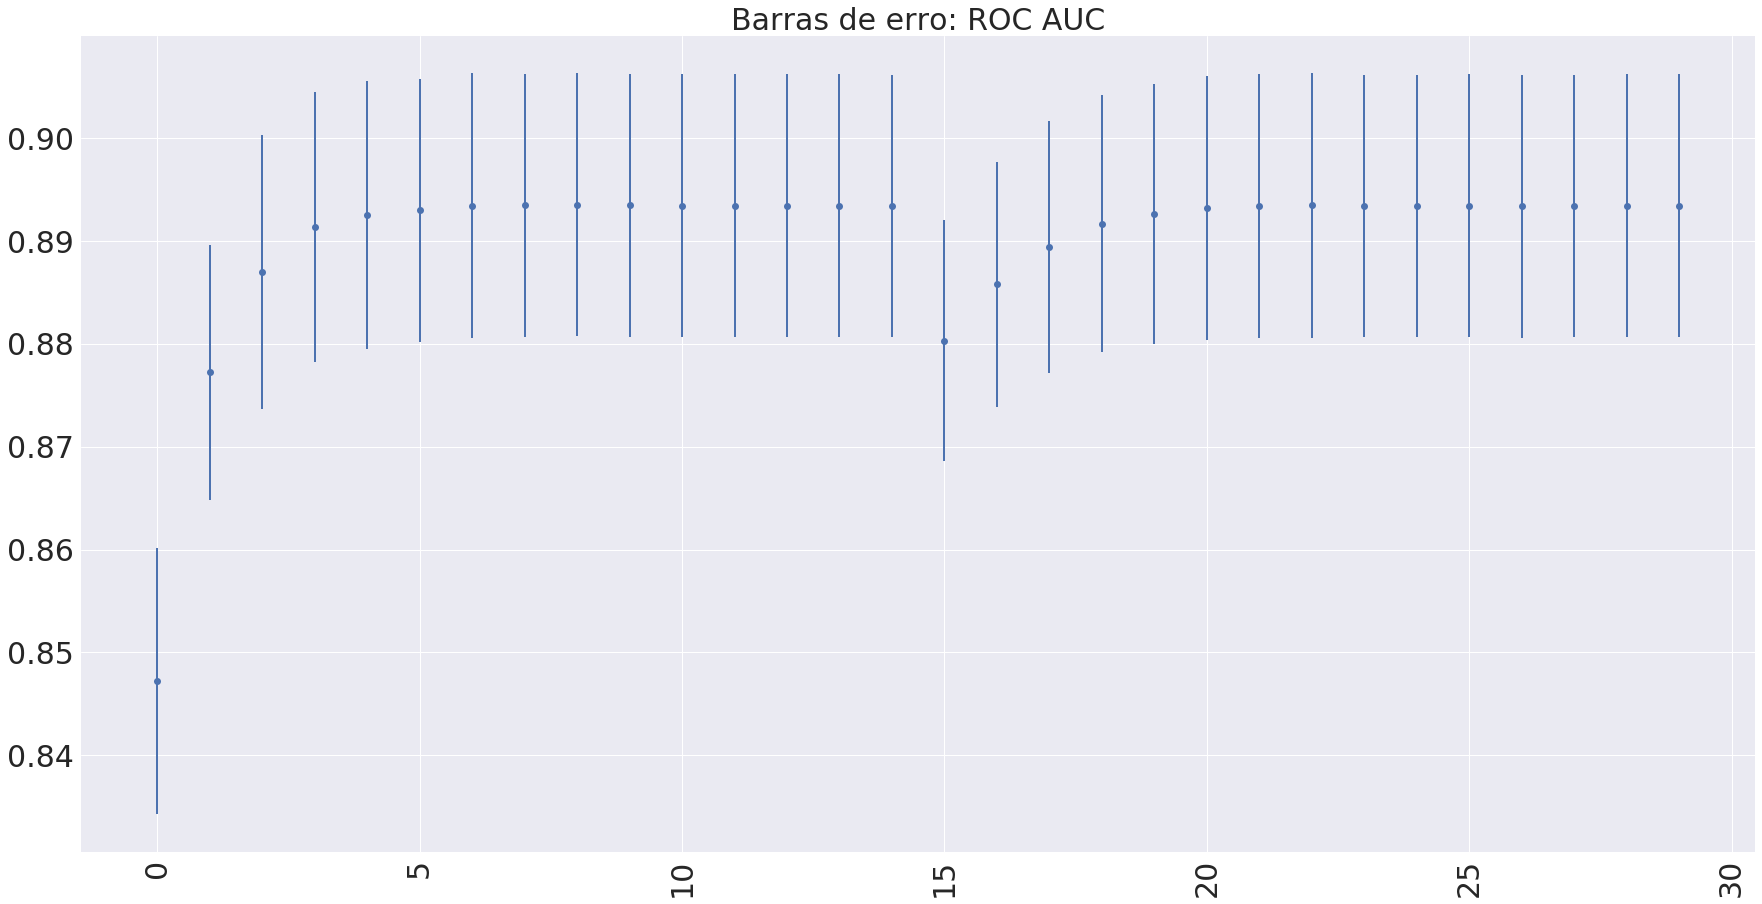

In [8]:
path_arquivos = 'Classificadores/Regressao-logistica/'
path_graficos = 'Classificadores/Regressao-logistica/graficos/'
str_balanceamento='balanceado'

clf_logit_balanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_balanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

# lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
    filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-erros-'+str(metrica[0])+'.png'
    plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

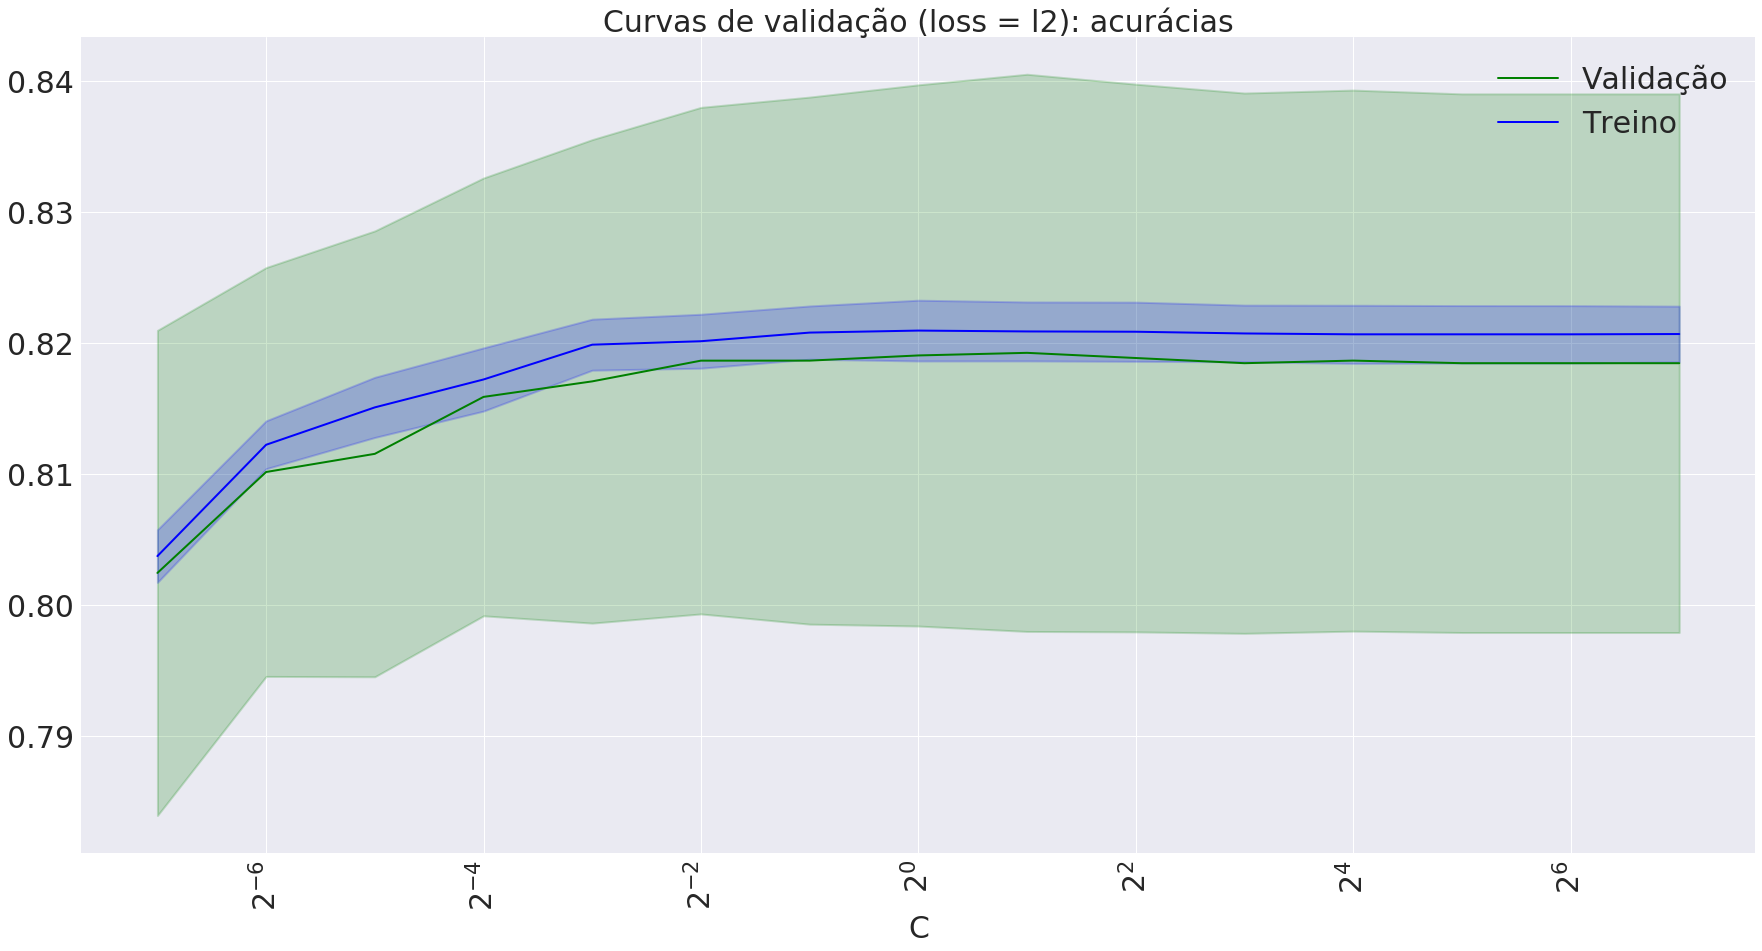

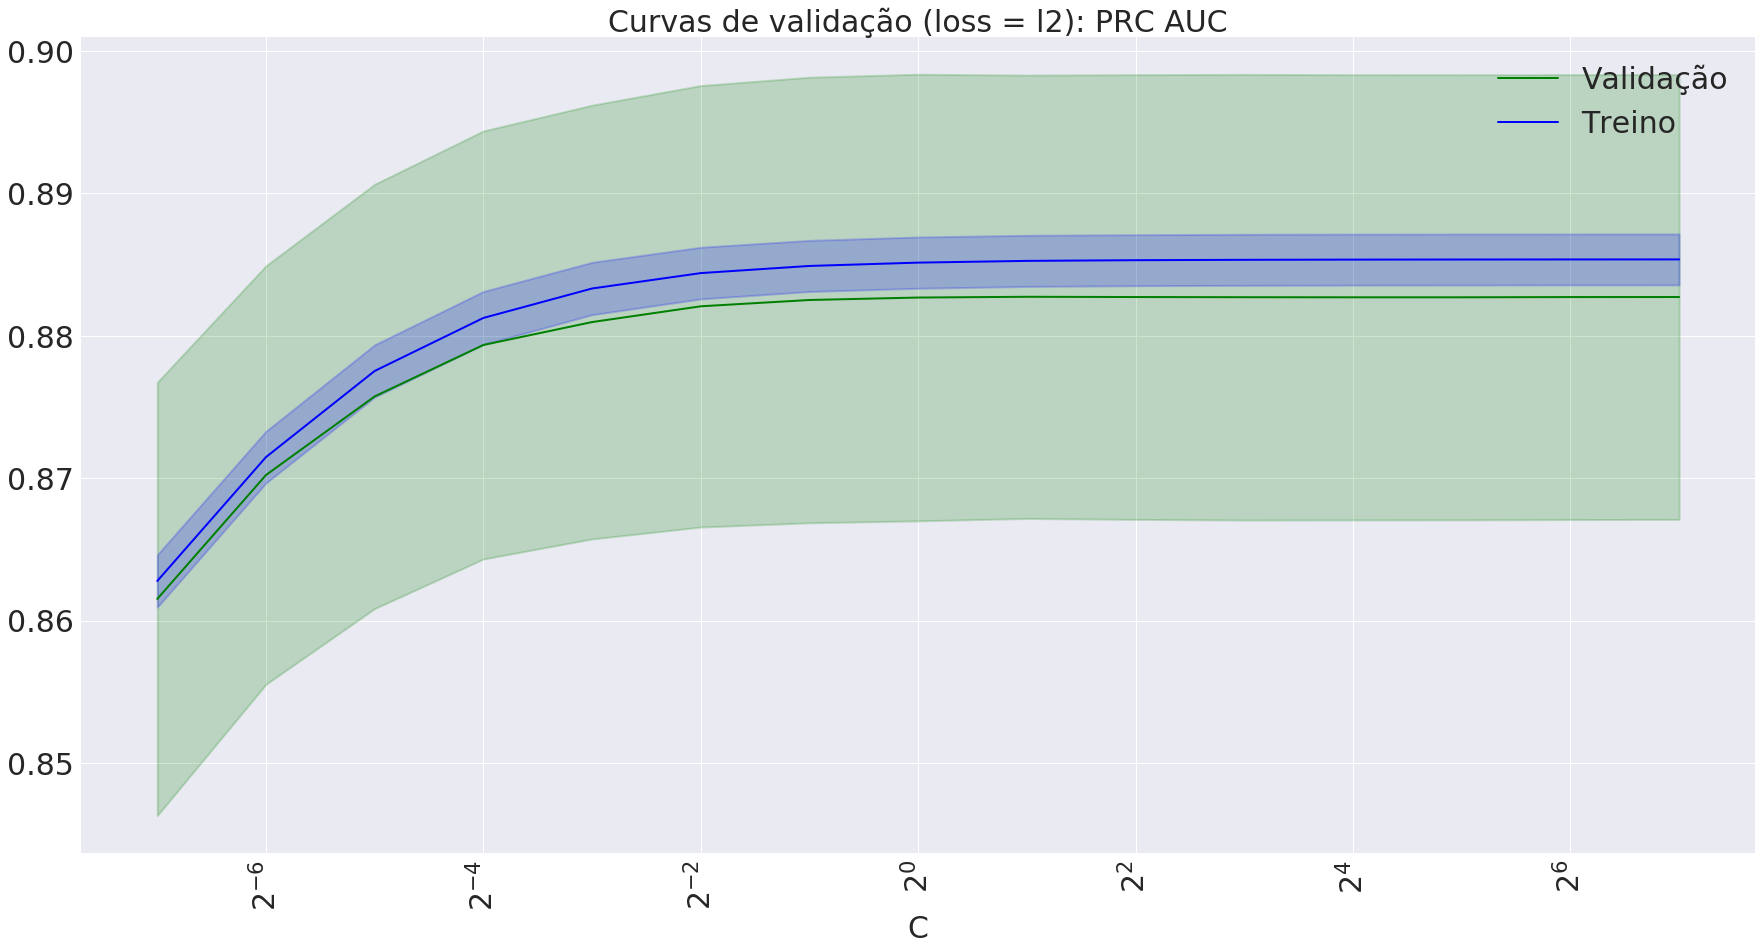

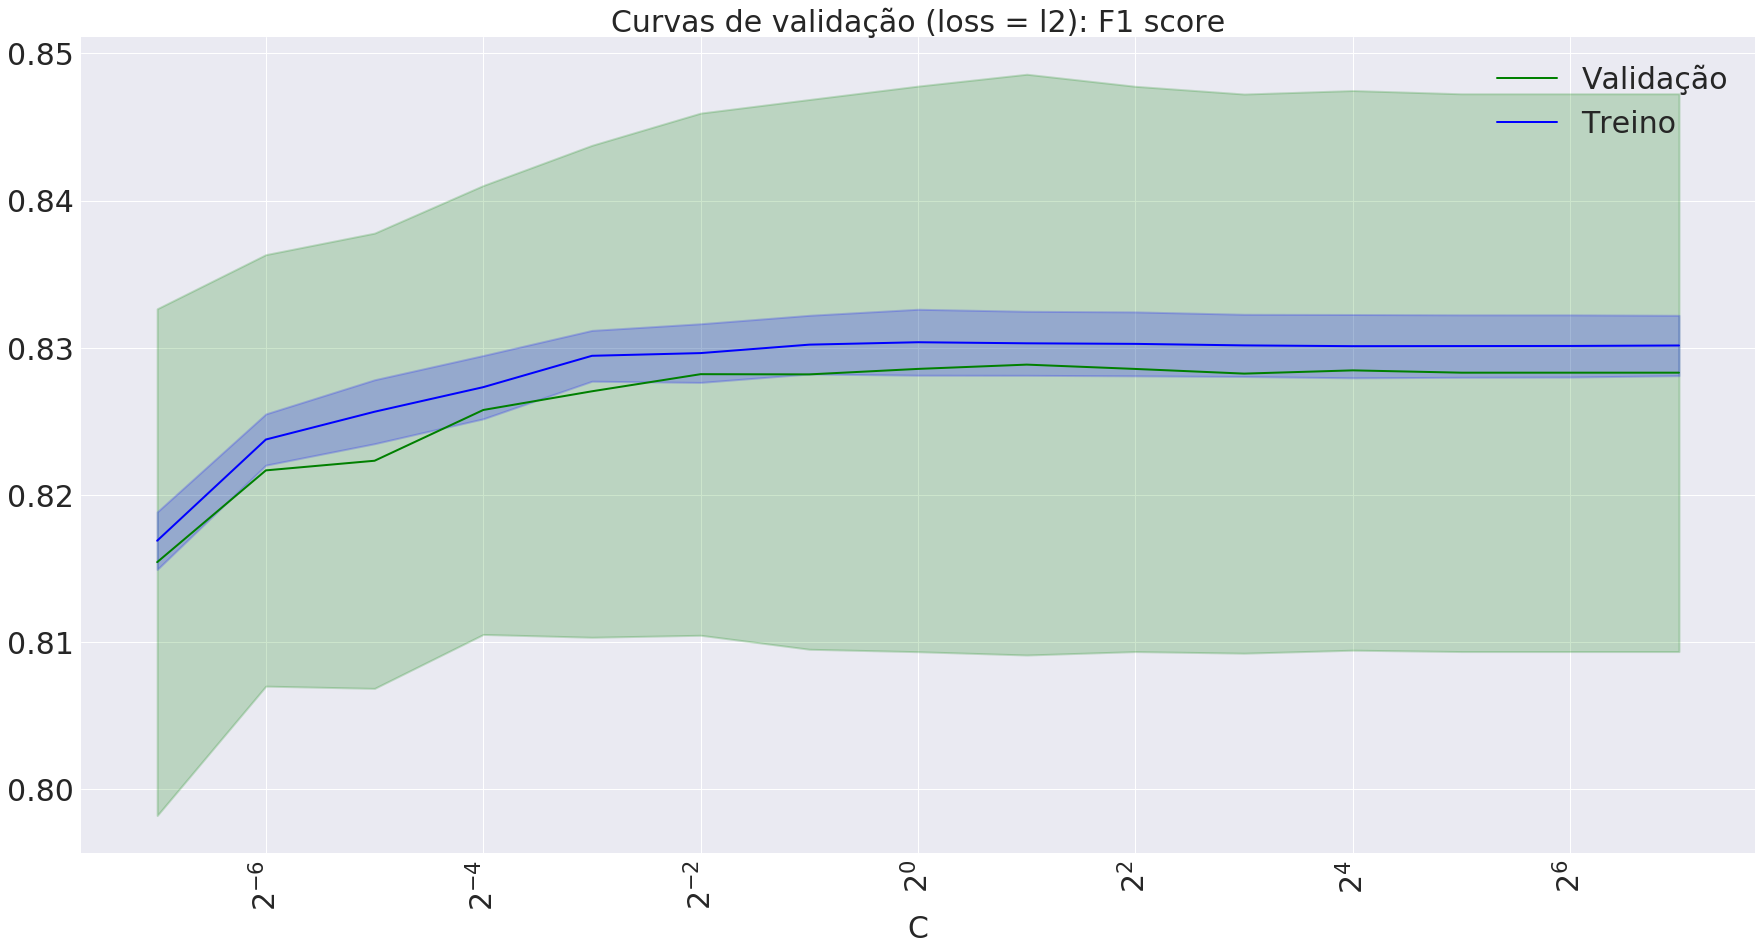

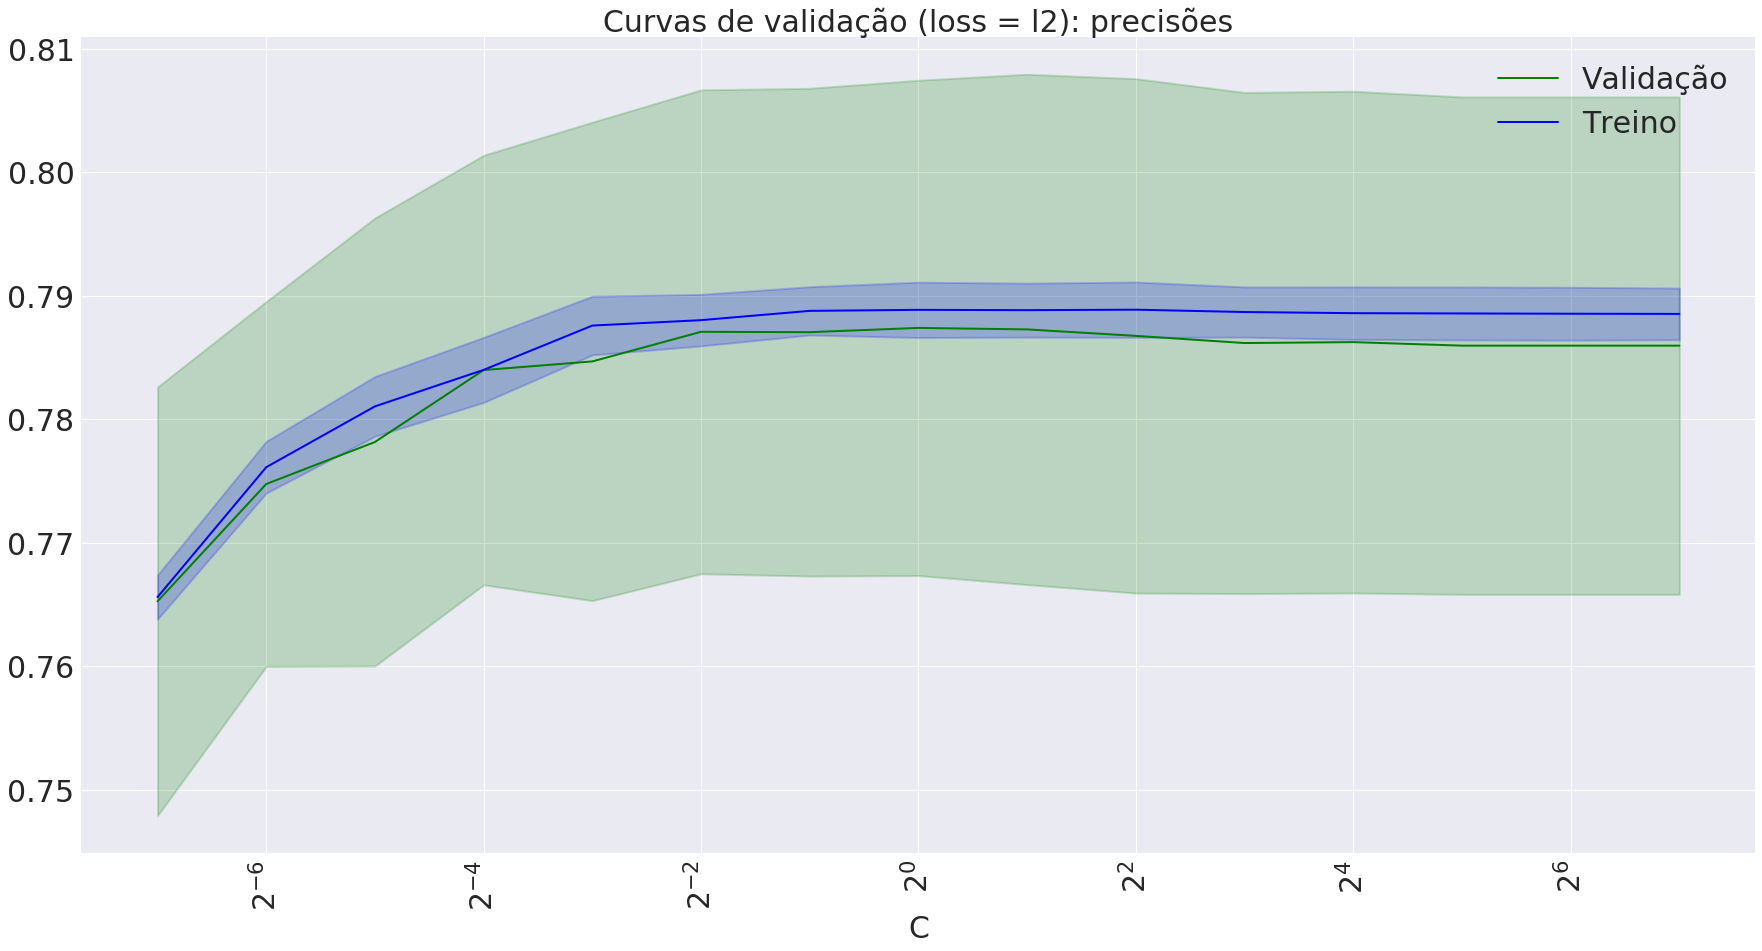

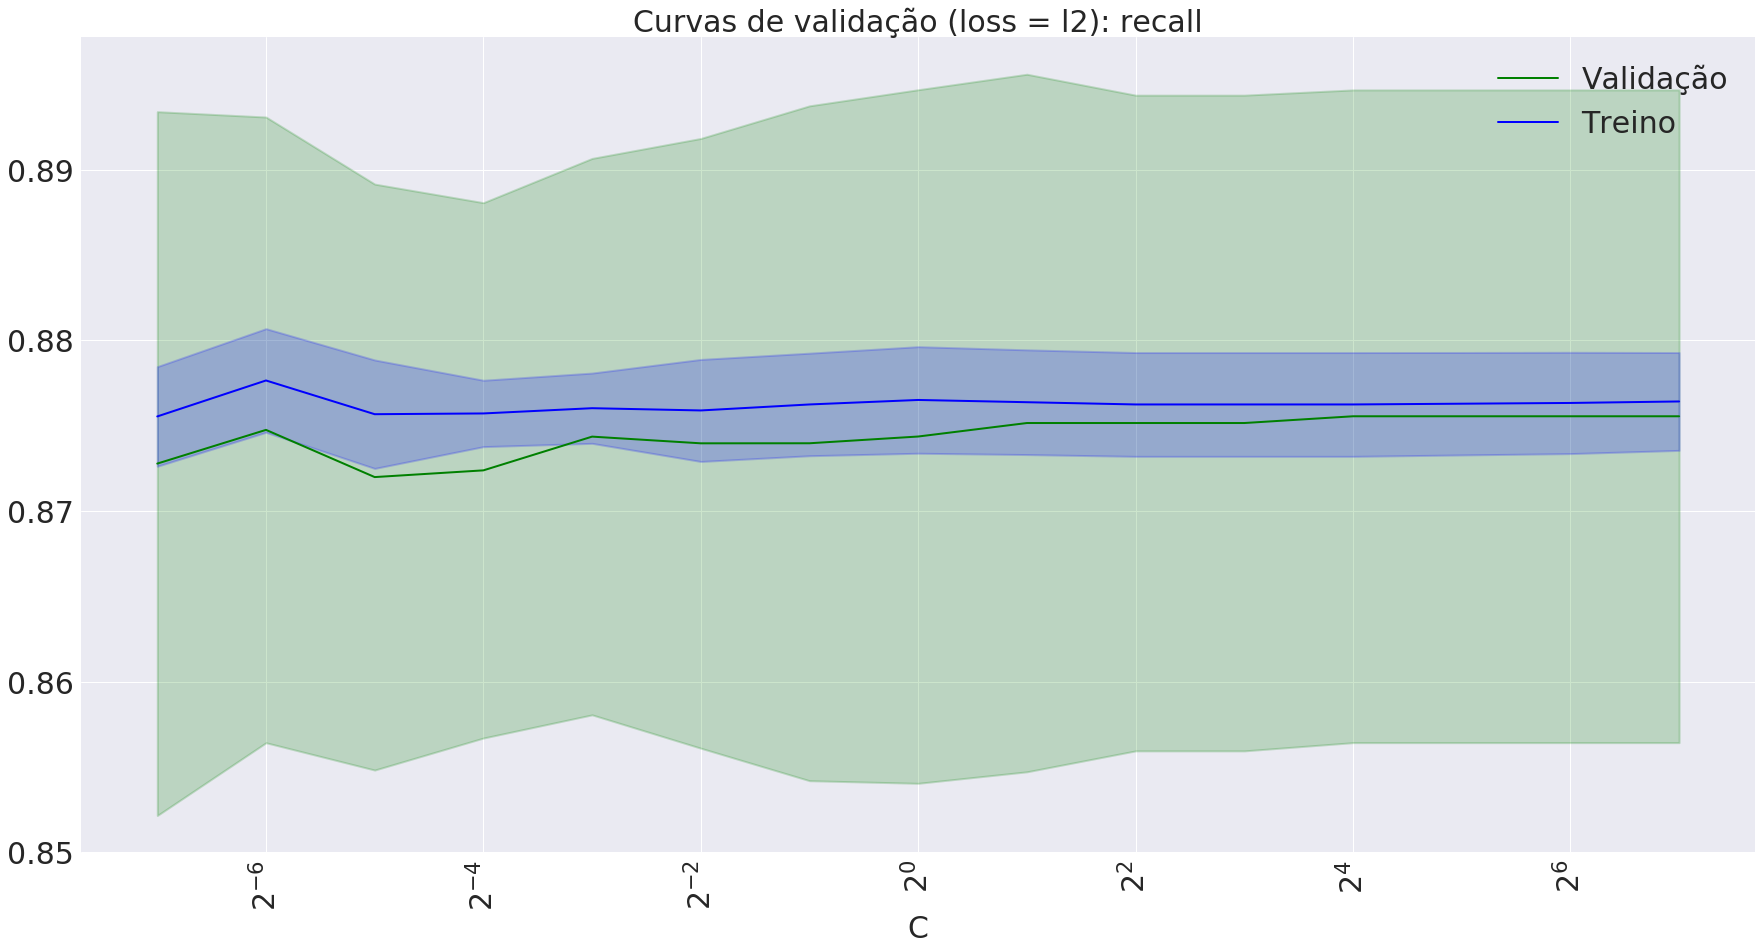

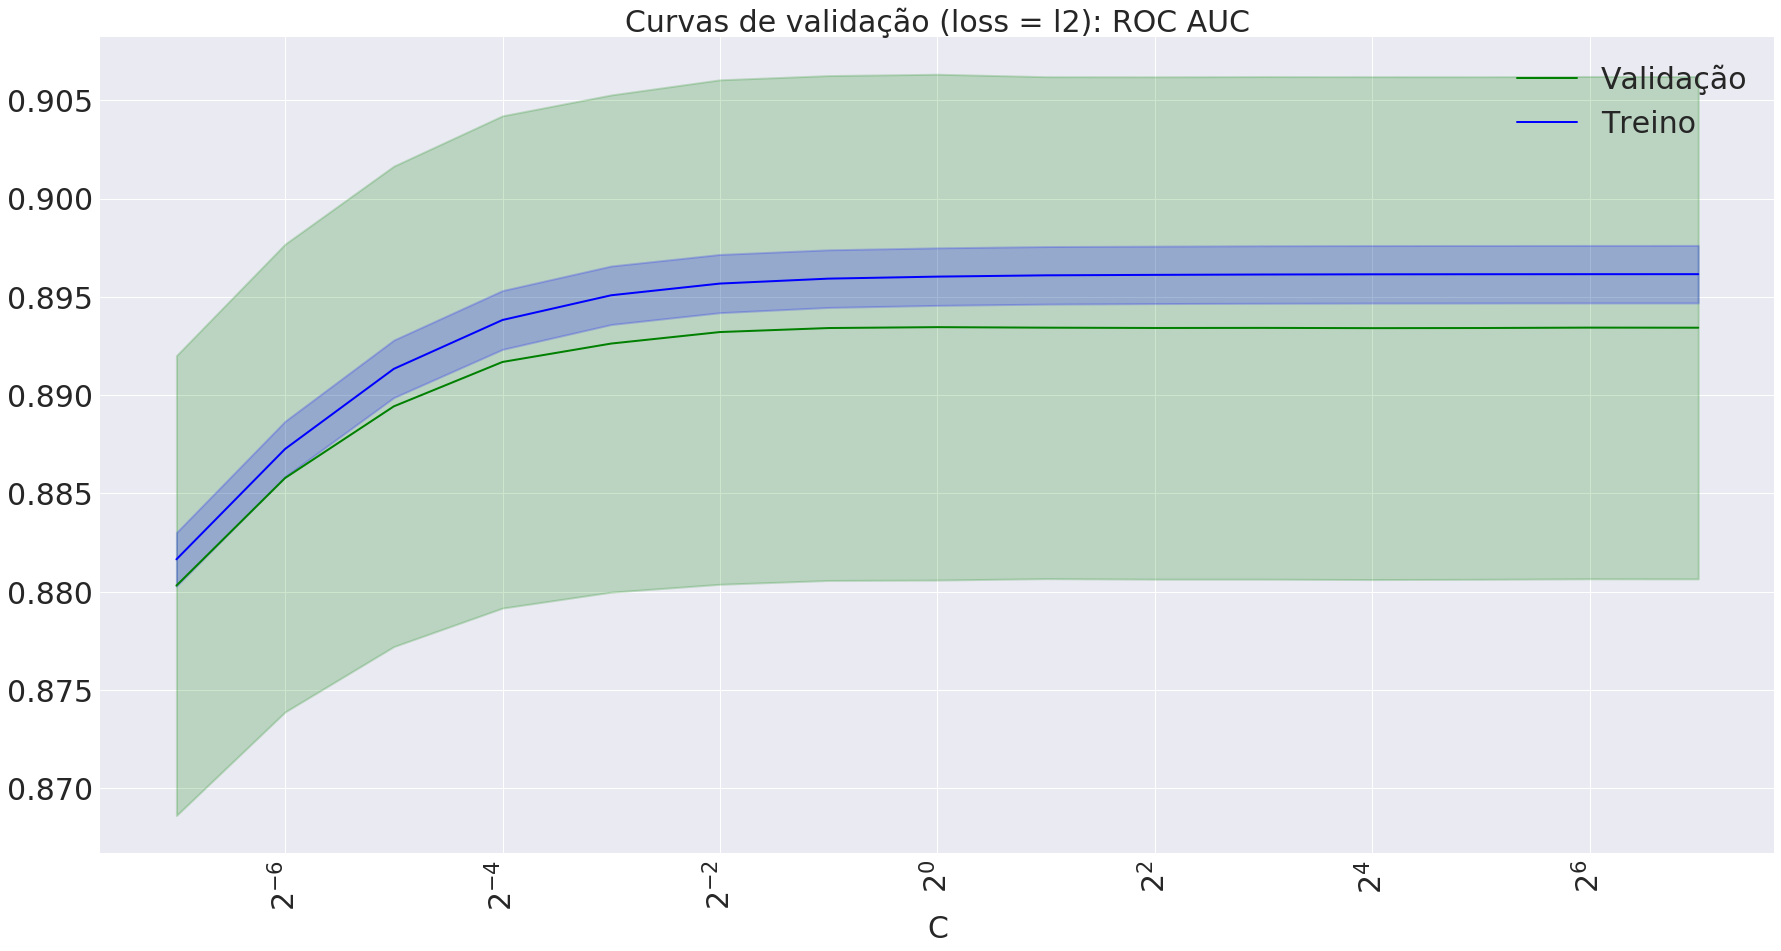

In [9]:
path_arquivos = 'Classificadores/Regressao-logistica/'
path_graficos = 'Classificadores/Regressao-logistica/graficos/'
str_balanceamento='balanceado'

C_step = 15
C_values = np.logspace(start=-7,stop=7,num=15,base=2)

# criterios = ['l2', 'l1']
criterios = ['l2']

for criterio in criterios:
    
    if criterio == 'l1':
        range_cols = list(range(0,int(results_test.shape[0]/2)))
    elif criterio == 'l2':
        range_cols = list(range(int(results_test.shape[0]/2),results_test.shape[0]))
    
    for metrica in lista_metricas:

        results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
        results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()
        
#         display(results_test_filtered.head(10))

#         results_test_filtered = results_test_filtered.iloc[:, 0:int((results_test_filtered.shape[1]/2))]
#         results_train_filtered = results_train_filtered.iloc[:, 0:int((results_train_filtered.shape[1]/2))]

        results_test_filtered = results_test_filtered.iloc[:, range_cols]
        results_train_filtered = results_train_filtered.iloc[:, range_cols]

        fig = plt.figure(figsize=(30,15))
        plt.semilogx(C_values, results_test_filtered.mean(), label='Validação', color='green', lw=2, basex=2)
        plt.fill_between(C_values, results_test_filtered.mean() - results_test_filtered.std(),
                     results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

        plt.semilogx(C_values, results_train_filtered.mean(), label='Treino', color='blue', lw=2, basex=2)
        plt.fill_between(C_values, results_train_filtered.mean() - results_train_filtered.std(),
                     results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
        plt.title('Curvas de validação (loss = '+ criterio + '): '+ metrica[1], fontsize=30)
        plt.xticks(fontsize=30, rotation=90)
        plt.xlabel('C', fontsize=30)
        plt.yticks(fontsize=30)
        plt.legend(loc='best', fontsize=30)
        
        filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+str(metrica[0])+'.png'
        plt.savefig(path_graficos+filename_graficos)
        
        plt.show()

In [26]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit = LogisticRegression(solver = 'liblinear', fit_intercept = False, C = 1, penalty = 'l2')

clf_logit.fit(pd.get_dummies(train_data_b_2), train_target_b_2)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-final-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Regressao-logistica/regressao-logistica-final-abordagem-2-balanceado-dataset-10pct.pkl']

Acurácia: 79.280 %
Precisão: 54.441 %
Recall: 85.309 %
F1 score: 66.465863 %
ROC AUC: 89.464 %
PRC AUC: 74.244 %


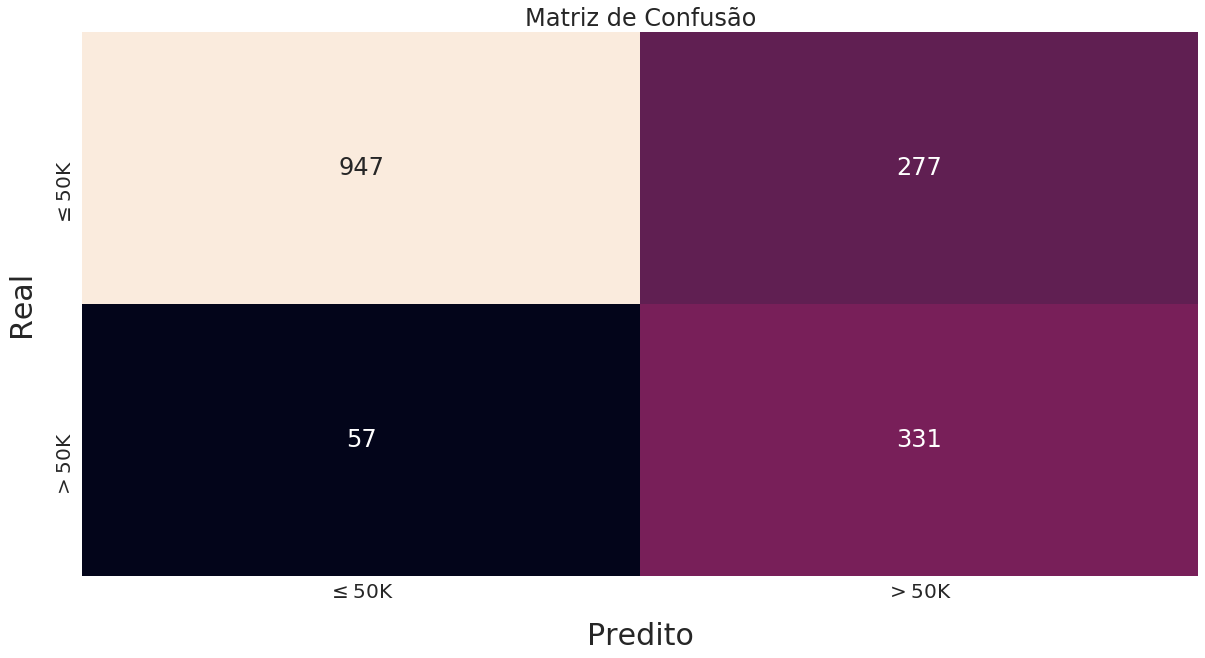

In [13]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_final_balanceado = joblib.load(path_arquivos+'regressao-logistica-final-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_final_balanceado, 
                         test_data=pd.get_dummies(test_data_2), 
                         test_target=test_target_2, 
                         id_abordagem=2, 
                         str_balanceamento='balanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='logit',
                         salvar_resultados=True)

In [ ]:
from sklearn.model_selection import learning_curve

path_arquivos = 'Classificadores/Regressao-logistica/'
path_graficos = 'Classificadores/Regressao-logistica/graficos/'
str_balanceamento='balanceado'

lista_metricas = [('accuracy', 'Acurácia'), ('precision', 'Precisão'), ('recall', 'Recall'), ('roc_auc', 'ROC AUC'), ('f1', 'F1 Score'), ('average_precision', 'PRC AUC')]

for metrica in lista_metricas:

    train_sizes, train_scores, test_scores = learning_curve(
            clf_final_balanceado, pd.get_dummies(train_data_b_2), train_target_b_2, cv=10, train_sizes=np.linspace(.1, 1.0, 50), 
            scoring=metrica[0])

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(30,15))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Validação")

    plt.ylabel(metrica[1], fontsize=30, labelpad=20)
    plt.xlabel('Tamanho Conjunto de Treino (amostras)', fontsize=30, labelpad=20)
    plt.title('Curvas de Aprendizado ('+str_balanceamento+')', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="best", fontsize=30)
    
    filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-curvas_aprendizado-'+str(metrica[0])+'.png'
    plt.savefig(path_graficos+filename_graficos)

    plt.show()

In [22]:
# Abordagem 3: Imputar valores faltantes e retirar outliers

path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit.fit(pd.get_dummies(train_data_3), train_target_3)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_logit.fit(pd.get_dummies(train_data_b_3), train_target_b_3)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Regressao-logistica/regressao-logistica-abordagem-3-balanceado-dataset-10pct.pkl']

In [23]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit_desbalanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_desbalanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

# lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'cv_results_'

In [ ]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit_balanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_balanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

# lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [ ]:
# Abordagem 2: Retirar valores faltantes e retirar outliers

path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit.fit(pd.get_dummies(train_data_4), train_target_4)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_logit.fit(pd.get_dummies(train_data_b_4), train_target_b_4)
joblib.dump(clf_logit, 
            path_arquivos+'regressao-logistica-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

In [ ]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit_desbalanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_desbalanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

# lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
    filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-erros-'+criterio+'-'+str(metrica[0])+'.png'
    plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

In [ ]:
path_arquivos = 'Classificadores/Regressao-logistica/'

clf_logit_balanceado = joblib.load(path_arquivos+'regressao-logistica-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_logit_balanceado.cv_results_)
results.sort_values(by=['param_penalty', 'param_C'], axis=0, inplace=True)

# display(results.loc[:, 'param_C':'params'].head(10))

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']

# display(results_test.head(10))
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

# lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

lista_metricas = [('accuracy', 'acurácias')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
#     display(results_test_filtered.head(10))

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
    filename_graficos = 'regressao-logistica-abordagem-2-'+str_balanceamento+'-erros-'+criterio+'-'+str(metrica[0])+'.png'
    plt.savefig(path_graficos+filename_graficos)
    
    plt.show()